In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as plticker
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib as mpl

import requests
import datetime
import copy
import math
import pickle
from tqdm.auto import tqdm
from datetime import timedelta, date
import time
import os
import numbers

import cel_utils.disk_utils as du

import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd

from jax import random
import numpyro
import numpyro.distributions as dist

import scenario_generator.curated as curated
import scenario_generator.mcmc_forecast as mcmc
import scenario_generator.utils as u

from mechafil.sim import run_simple_sim
from mechafil.data import get_historical_network_stats, get_sector_expiration_stats, \
    get_cum_capped_qa_power, setup_spacescope, get_vested_amount
from mechafil.power import forecast_power_stats, build_full_power_stats_df
from mechafil.vesting import compute_vesting_trajectory_df
from mechafil.minting import compute_minting_trajectory_df, \
    network_time, cum_baseline_reward, compute_baseline_power_array, \
    get_cum_capped_rb_power
from mechafil.supply import forecast_circulating_supply_df
from mechafil.constants import EIB, PIB
import pystarboard.data

## NOTE: This code uses mechaFIL in a non-standard way. To reproduce the results,
#   the `update_policy` branch of mechaFIL needs to be used - not the main branch.
#   https://github.com/protocol/filecoin-mecha-twin/tree/update_policy
# This comment is relevant as of 16-Sep-2023.

In [4]:
NDEVICES = 2 
numpyro.set_host_device_count(NDEVICES)

# Data starts in filecoin_daily_stats 2021-03-15
# genesis block was in 2020-08-24
# Main net launch was in 2020-10-15

# set the simulation start date
current_date = datetime.date(2023, 9, 30) 
current_day = (current_date - datetime.date(2020, 10, 15)).days

start_date = datetime.date(2023, 9, 1)  # reduce locking bias by starting simulation close to current date
start_day = (start_date - datetime.date(2020, 10, 15)).days

# Forecast timeframe
forecast_lenght = int(365*3)
end_day = current_day + forecast_lenght
end_date = current_date + datetime.timedelta(days=forecast_lenght)

print(start_date)
print(current_date)
print(end_date)

2023-09-01
2023-09-30
2026-09-29


In [5]:
root_folder = '/Users/kiran/Documents/universal_multipliers/'
offline_folder = os.path.join(root_folder, 'offline_info')
results_folder = os.path.join(root_folder, 'results')
os.makedirs(offline_folder, exist_ok=True)
os.makedirs(results_folder, exist_ok=True)

# helpful constants
TIB = 2 ** 40
GIB = 2 ** 30

SECTOR_SIZE = 32 * GIB
EPOCH_PER_DAY = 2880
MEGA = 1_000_000

setup_spacescope('/Users/kiran/code/auth/kiran_spacescope_auth.json')
pystarboard.data.setup_spacescope('/Users/kiran/code/auth/kiran_spacescope_auth.json')

In [6]:
@du.cache_data(directory=offline_folder)
def download_historical_data():
    t_hist_rbp, hist_rbp = u.get_historical_daily_onboarded_power(start_date, current_date)
    t_hist_rr, hist_rr = u.get_historical_renewal_rate(start_date, current_date)
    t_hist_fpr, hist_fpr = u.get_historical_filplus_rate(start_date, current_date)

    fil_stats_df = get_historical_network_stats(start_date,current_date,end_date)
    sector_expiration_stats_offline = get_sector_expiration_stats(start_date, current_date,end_date)
    
    network_baseline = compute_baseline_power_array(start_date, end_date)
    zero_cum_capped_power = get_cum_capped_rb_power(start_date)
    
    start_vest_amt = get_vested_amount(start_date)

    dict_out = {
        't_rbp': t_hist_rbp,
        'hist_rbp': hist_rbp,
        't_rr': t_hist_rr,
        'historical_renewal_rate': hist_rr,
        't_fpr': t_hist_fpr,
        'historical_fpr': hist_fpr,
        'fil_stats_df': fil_stats_df,
        'sector_expiration_stats_offline': sector_expiration_stats_offline,
        'network_baseline': network_baseline,
        'zero_cum_capped_power': zero_cum_capped_power,
        'start_vest_amt': start_vest_amt
    }
    
    return dict_out
    
historical_data = download_historical_data()
globals().update(**historical_data)

In [7]:
## the main simulation library functions

def baseline_storage(epoch:float)->float:
    # Spec value:
    # BASELINE_B0 = 2.88888888 
    # The following value is required to match sentinel
    # to Reproduce the first baseline crossing in backtest.
    # It's also close to the value the starboard use: 2.77. 
    # !Someone should look more closely at this.
    BASELINE_B0 = 2.7636 
    BASELINE_R = np.log(2) / (2880*365) # 1_051_200 in eopchs
    EPOCH_PER_DAY = 2880
    return BASELINE_B0 * np.exp(BASELINE_R * epoch)

# find baseline crossings
def find_crossings(df:pd.DataFrame)->pd.DataFrame:
    xing = np.array([])
    for i in range(df.iter[-1]+1):
        df_i = df[df['iter'] == i]
        df_crossing = df_i[df_i.network_RBP.values/EIB < baseline]
        if len(df_crossing) > 0:
            xing_i = df_i[df_i.network_RBP.values/EIB < baseline].index[0]
            xing = np.append(xing,xing_i)
    return xing

def clip_all_powers(df_in):
    """
    'onboarded_power', 'cum_onboarded_power',
    'expire_scheduled_power', 'cum_expire_scheduled_power', 'renewed_power',
    'cum_renewed_power', 'total_power', 'power_type', 'total_qa_power_eib'
    """
    df_out = df_in.copy()
    for c in df_out.columns:
        if 'power' in c and c != 'power_type':
#             df_out[c] = df_out[c].clip(lower=1e-4)
            df_out[c] = df_out[c].clip(lower=0)
    return df_out

# add ROI to trajectory
def add_generated_quantities(cil_rbp, duration=365)->pd.DataFrame:
    # add ROI to trajectory df
#     df['day_pledge_per_QAP'] = SECTOR_SIZE * df['day_locked_pledge'] / (df['day_onboarded_power_QAP'] + df['day_renewed_power_QAP'])
    cil_rbp['day_pledge_per_QAP'] = SECTOR_SIZE * (cil_rbp['day_locked_pledge']-cil_rbp['day_renewed_pledge'])/(cil_rbp['day_onboarded_power_QAP'])
    cil_rbp['day_rewards_per_sector'] = SECTOR_SIZE * cil_rbp.day_network_reward / cil_rbp.network_QAP
    cil_rbp['1y_return_per_sector'] = cil_rbp['day_rewards_per_sector'].rolling(365).sum().shift(-365+1).values.flatten()
    cil_rbp['1y_sector_roi'] = cil_rbp['1y_return_per_sector'] / cil_rbp['day_pledge_per_QAP']

    duration_yr = duration/365
    cil_rbp['duration_return_per_sector'] = cil_rbp['day_rewards_per_sector'].rolling(duration).sum().shift(-duration+1).values.flatten()
    cil_rbp['duration_sector_roi'] = cil_rbp['duration_return_per_sector'] / cil_rbp['day_pledge_per_QAP']
    cil_rbp['duration_roi_annualized'] = np.power(cil_rbp['duration_sector_roi'] + 1, 1/duration_yr) - 1
    return cil_rbp

def run_sim(
    rb_onboard_power_pred_IN, 
    renewal_rate_vec_pred_IN, 
    fil_plus_rate_pred_IN,
    duration=365, 
    cc_multiplier_fn = None,
    cc_multiplier_fn_kwargs = None,
    filp_multiplier_fn = None,
    filp_multiplier_fn_kwargs = None,
    qap_mode='basic', 
    intervention_config={},
    sector_expiration_stats_IN=sector_expiration_stats_offline
):
    # api for power-forecasting and circ-supply are slightly different
    renewal_rate_vec_IN = np.concatenate([historical_renewal_rate, renewal_rate_vec_pred_IN])    

    if sector_expiration_stats_IN is None:
        res = get_sector_expiration_stats(start_date, current_date,end_date)
    else:
        res = sector_expiration_stats_IN
    rb_known_scheduled_expire_vec = res[0]
    qa_known_scheduled_expire_vec = res[1]
    known_scheduled_pledge_release_full_vec = res[2]
    
    current_day_stats = fil_stats_df.iloc[-1]
    
    rb_power_zero = current_day_stats["total_raw_power_eib"] * 1024.0
    qa_power_zero = current_day_stats["total_qa_power_eib"] * 1024.0

    rb_power_df, qa_power_df = forecast_power_stats(
        rb_power_zero,
        qa_power_zero,
        rb_onboard_power_pred_IN,
        rb_known_scheduled_expire_vec,
        qa_known_scheduled_expire_vec,
        renewal_rate_vec_IN[-int(forecast_lenght):],
        fil_plus_rate_pred_IN,
        duration,
        forecast_lenght,
        fil_plus_m = 10,
        cc_multiplier_fn = cc_multiplier_fn,
        cc_multiplier_fn_kwargs = cc_multiplier_fn_kwargs,
        filp_multiplier_fn = filp_multiplier_fn,
        filp_multiplier_fn_kwargs = filp_multiplier_fn_kwargs,
        qap_method=qap_mode,
        intervention_config=intervention_config,
        fpr_hist_info=(t_fpr, historical_fpr)
    )

    ########## BUG FIX
    rb_power_df = clip_all_powers(rb_power_df)
    qa_power_df = clip_all_powers(qa_power_df)
    ##########
    rb_power_df["total_raw_power_eib"] = rb_power_df["total_power"]/1024.0
    qa_power_df["total_qa_power_eib"] = qa_power_df["total_power"]/1024.0
        
    power_df = build_full_power_stats_df(
        fil_stats_df,
        rb_power_df,
        qa_power_df,
        start_date,
        current_date,
        end_date,
    )
    
    rb_total_power_eib = power_df["total_raw_power_eib"].values
    qa_total_power_eib = power_df["total_qa_power_eib"].values
    qa_day_onboarded_power_pib = power_df["day_onboarded_qa_power_pib"].values
    qa_day_renewed_power_pib = power_df["day_renewed_qa_power_pib"].values

    vest_df = compute_vesting_trajectory_df(start_date, end_date, start_vest_amt=historical_data['start_vest_amt'])
    
    mint_df_rbpbase = compute_minting_trajectory_df(
        start_date,
        end_date,
        rb_total_power_eib,
        qa_total_power_eib,
        qa_day_onboarded_power_pib,
        qa_day_renewed_power_pib,
        minting_base = 'rbp',
        baseline_power_array = network_baseline,
        zero_cum_capped_power = zero_cum_capped_power
    )
    
    start_day_stats = fil_stats_df.iloc[0]
    circ_supply_zero = start_day_stats["circulating_fil"]
    locked_fil_zero = start_day_stats["locked_fil"]
    burnt_fil_zero = start_day_stats["burnt_fil"]
    daily_burnt_fil = fil_stats_df["burnt_fil"].diff().mean()
    burnt_fil_vec = fil_stats_df["burnt_fil"].values

    cil_df_rbp = forecast_circulating_supply_df(
        start_date,
        current_date,
        end_date,
        circ_supply_zero,
        locked_fil_zero,
        daily_burnt_fil,
        duration,
        renewal_rate_vec_IN,
        burnt_fil_vec,
        vest_df,
        mint_df_rbpbase,
        known_scheduled_pledge_release_full_vec,
        fil_plus_rate=fil_plus_rate_pred_IN,
        intervention_config=intervention_config,
        fpr_hist_info=(t_fpr, historical_fpr)
    )
    
    rbp_roi = add_generated_quantities(cil_df_rbp, duration=duration)
    
    return_dict = {
        'power_df': power_df,
        'rb_power_df': rb_power_df,
        'qa_power_df': qa_power_df,
        'mint_df': mint_df_rbpbase,
        'rbp_roi': rbp_roi,
        'renewal_rate_vec': renewal_rate_vec_IN,
        'rb_onboard_power_pred': rb_onboard_power_pred_IN,
        'fil_plus_rate_pred': fil_plus_rate_pred_IN
    }
    
    return return_dict

In [8]:
median_rbp = np.median(hist_rbp[-30:])
median_rr = np.median(historical_renewal_rate[-30:])
median_fpr = np.median(historical_fpr[-30:])

print(median_rbp, median_rr, median_fpr)

5.40380859375 0.6005997311737686 0.9356473724862046


In [9]:
# note that the input is *ADDITIONAL* multiplier on top of the 1x/10x - which is the current protocol
def const_2_5(): return 2.5
def const_5(): return 5
def const_1(): return 1
def const_2(): return 2
multiplier_cfgs = [
    {
        'name': '2.5x,10x',
        'cc_multiplier_fn': const_2_5,    # Implies CC/RD = 2.5x
        'cc_multiplier_fn_kwargs': {},
        'filp_multiplier_fn': const_1,  # implies FILP = 10x
        'filp_multiplier_fn_kwargs': {},
    },
    {
        'name': '5x,10x',
        'cc_multiplier_fn': const_5,    # Implies CC/RD = 5x
        'cc_multiplier_fn_kwargs': {},
        'filp_multiplier_fn': const_1,  # implies FILP = 10x
        'filp_multiplier_fn_kwargs': {},
    },
    {
        'name': '5x,20x',
        'cc_multiplier_fn': const_5,    # Implies CC/RD = 5x
        'cc_multiplier_fn_kwargs': {},
        'filp_multiplier_fn': const_2,  # implies FILP = 20x
        'filp_multiplier_fn_kwargs': {},
    }
]

In [10]:
#intervention_date=datetime.date(2023,1,15)
intervention_date = current_date + timedelta(days=90)
intervention_offset = 90
num_days_shock_behavior = 360
avg_sector_duration = 360
cc_reonboard_time_days = 1
cc_reonboard_delay_days = 1  #noop for all sector variants

qap_mode = 'tunable'

no_sdm = {
    'name': 'StatusQuo',
    'rbp': np.ones(forecast_lenght)*median_rbp,
    'rr': np.ones(forecast_lenght)*median_rr,
    'fpr': np.ones(forecast_lenght)*median_fpr,
    'kwargs':{
        'duration': avg_sector_duration, 
        'cc_multiplier_fn': const_1,  # ==> RBP = 1x
        'cc_multiplier_fn_kwargs': {},
        'filp_multiplier_fn': const_1,  # ==> QAP ==> 10x
        'filp_multiplier_fn_kwargs': {},
        'qap_mode':qap_mode,
        'intervention_config': {
            'type': 'noop',
            'num_days_shock_behavior': num_days_shock_behavior,
            'intervention_date': intervention_date,
            'cc_reonboard_time_days': cc_reonboard_time_days,
            'cc_reonboard_delay_days': cc_reonboard_delay_days,
            'simulation_start_date': current_date + datetime.timedelta(days=1),
            'update_onboard_power_multiplier_before_intervention': False,
            'update_onboard_power_multiplier_after_intervention': False,
            'update_renew_power_multiplier_before_intervention': False,
            'update_renew_power_multiplier_after_intervention': False
        }
    }
}
sim_vec = []
sim_vec.append(copy.deepcopy(no_sdm))

rbp_slopes = [1, 1.5, 2]  # units of pib/360 days??
filp_decrease_factor_vec = [1, .8, .5]
for multiplier_cfg in multiplier_cfgs:
    multiplier_cfg_in = copy.copy(multiplier_cfg)
    multiplier_cfg_in.pop('name')
    for rbp_slope in rbp_slopes:
        for filp_decrease_vector in filp_decrease_factor_vec:
            nn_append = '%s-RBPFactor=%0.02fx-FilpDecrease=%0.02f' % \
                (multiplier_cfg['name'], rbp_slope, filp_decrease_vector)

            rbp_trajectory = np.ones(forecast_lenght)*median_rbp
            rr_trajectory = np.ones(forecast_lenght)*median_rr
            fpr_trajectory = np.ones(forecast_lenght)*median_fpr
            fpr_trajectory[intervention_offset:] *= filp_decrease_vector
            
            # model the increase in onboarding due to policy change
            if rbp_slope > 1:
                t_slope = np.arange(0,forecast_lenght-intervention_offset)
                rbp_trajectory[intervention_offset:] += (rbp_slope/360.)*t_slope

            scenario_1a = {
                'name': '%s' % (nn_append,),  
                'rbp': rbp_trajectory,
                'rr': rr_trajectory,
                'fpr': fpr_trajectory,
                'kwargs':{
                    'duration': avg_sector_duration, 
                    'cc_multiplier_fn': multiplier_cfg_in['cc_multiplier_fn'],
                    'cc_multiplier_fn_kwargs': multiplier_cfg_in['cc_multiplier_fn_kwargs'],
                    'filp_multiplier_fn': multiplier_cfg_in['filp_multiplier_fn'],
                    'filp_multiplier_fn_kwargs': multiplier_cfg_in['filp_multiplier_fn_kwargs'],
                    'qap_mode':qap_mode,
                    'intervention_config': {
                        'type': 'noop',
                        'num_days_shock_behavior': num_days_shock_behavior,
                        'intervention_date': intervention_date,
                        'cc_reonboard_time_days': cc_reonboard_time_days,
                        'cc_reonboard_delay_days': cc_reonboard_delay_days,
                        'simulation_start_date': current_date + datetime.timedelta(days=1),
                        'update_onboard_power_multiplier_before_intervention': False,
                        'update_onboard_power_multiplier_after_intervention': True,
                        'update_renew_power_multiplier_before_intervention': False,
                        'update_renew_power_multiplier_after_intervention': True
                  }
              }
            }

            sim_vec.append(copy.deepcopy(scenario_1a))

In [11]:
def exec_sims():
    results = {}
    for sim in tqdm(sim_vec):
        kwargs = sim['kwargs']
        return_dict = run_sim(sim['rbp'], sim['rr'], sim['fpr'], **kwargs)
        results[sim['name']] = return_dict
    return {'results': results}
results = exec_sims()
globals().update(**results)

  0%|          | 0/28 [00:00<?, ?it/s]

In [12]:
# global plot configs
plt_statusquo = True
multiplier_cfgs = [
    '2.5x,10x',
    '5x,10x',
    '5x,20x'
]
cmaps = [mpl.colormaps['Blues'], mpl.colormaps['Oranges'], mpl.colormaps['Greens']]
cmap_access_vec = np.linspace(0.1, 0.9, len(rbp_slopes))

no_sdm = results['StatusQuo']['rbp_roi']

min_time = no_sdm['date'].iloc[0]
max_time = current_date + datetime.timedelta(days=365*4)

In [13]:
def get_negligible_costs(bandwidth_10gbps_tib_per_yr):
    # Definitions (we can make these configurable later, potentially)
    sealing_costs_tib_per_yr = 1.3

    gas_cost_tib_per_yr = (2250.+108.)/1024.
    gas_cost_without_psd_tib_per_yr = 108./1024.
    bandwidth_1gbps_tib_per_yr=bandwidth_10gbps_tib_per_yr/10.0

    return sealing_costs_tib_per_yr, gas_cost_tib_per_yr, gas_cost_without_psd_tib_per_yr, bandwidth_1gbps_tib_per_yr


def compute_costs(expected_rewards_per_tib, 
                  filp_multiplier=10, rd_multiplier=1, cc_multiplier=1,
                  exchange_rate=4.0, borrowing_cost_pct=0.50,
                  filp_bd_cost_tib_per_yr=8.0, rd_bd_cost_tib_per_yr=3.2,
                  deal_income_tib_per_yr=16.0,
                  data_prep_cost_tib_per_yr=1.0, penalty_tib_per_yr=10.0,
                  power_cost_tib_per_yr=6, 
                  bandwidth_10gbps_tib_per_yr=6, 
                  staff_cost_tib_per_yr=8
                  ):
    erpt = expected_rewards_per_tib
    
    sealing_costs_tib_per_yr, gas_cost_tib_per_yr, gas_cost_without_psd_tib_per_yr, bandwidth_1gbps_tib_per_yr = get_negligible_costs(bandwidth_10gbps_tib_per_yr)
    
    # create a dataframe for each of the miner profiles
    filp_miner = {
        'SP Type': 'FIL+',
        'block_rewards': erpt*exchange_rate*filp_multiplier,
        'deal_income': deal_income_tib_per_yr,
        'pledge_cost': erpt*exchange_rate*filp_multiplier*borrowing_cost_pct,
        'gas_cost': gas_cost_tib_per_yr,
        'power_cost': power_cost_tib_per_yr,
        'bandwidth_cost': bandwidth_10gbps_tib_per_yr,
        'staff_cost': staff_cost_tib_per_yr,
        'sealing_cost': sealing_costs_tib_per_yr,
        'data_prep_cost': data_prep_cost_tib_per_yr,
        'bd_cost': filp_bd_cost_tib_per_yr,
        'extra_copy_cost': (staff_cost_tib_per_yr+power_cost_tib_per_yr)*0.5,
        'cheating_cost': 0
    }
    rd_miner = {
        'SP Type': 'Regular Deal',
        'block_rewards': erpt*exchange_rate*rd_multiplier,
        'deal_income': deal_income_tib_per_yr,
        'pledge_cost': erpt*exchange_rate*rd_multiplier*borrowing_cost_pct,
        'gas_cost': gas_cost_tib_per_yr,
        'power_cost': power_cost_tib_per_yr,
        'bandwidth_cost': bandwidth_10gbps_tib_per_yr,
        'staff_cost': staff_cost_tib_per_yr,
        'sealing_cost': sealing_costs_tib_per_yr,
        'data_prep_cost': data_prep_cost_tib_per_yr,
        'bd_cost': rd_bd_cost_tib_per_yr,
        'extra_copy_cost': (staff_cost_tib_per_yr+power_cost_tib_per_yr)*0.5,
        'cheating_cost': 0
    }
    filp_exploit_miner = {
        'SP Type':'V1-ExploitFIL+',
        'block_rewards': erpt*exchange_rate*filp_multiplier,
        'deal_income': 0,
        'pledge_cost': erpt*exchange_rate*filp_multiplier*borrowing_cost_pct,
        'gas_cost': gas_cost_tib_per_yr,
        'power_cost': power_cost_tib_per_yr,
        'bandwidth_cost': bandwidth_1gbps_tib_per_yr,
        'staff_cost': staff_cost_tib_per_yr,
        'sealing_cost': sealing_costs_tib_per_yr,
        'data_prep_cost': 1,
        'bd_cost': 0,
        'extra_copy_cost': 0,
        'cheating_cost': 0
    }
    filp_exploit_with_retrieval = {
        'SP Type':'V2-ExploitFIL+',
        'block_rewards': erpt*exchange_rate*filp_multiplier,
        'deal_income': 0,
        'pledge_cost': erpt*exchange_rate*filp_multiplier*borrowing_cost_pct,
        'gas_cost': gas_cost_tib_per_yr,
        'power_cost': power_cost_tib_per_yr,
        'bandwidth_cost': bandwidth_10gbps_tib_per_yr,
        'staff_cost': staff_cost_tib_per_yr,
        'sealing_cost': sealing_costs_tib_per_yr,
        'data_prep_cost': 1,
        'bd_cost': 0,
        'extra_copy_cost': (staff_cost_tib_per_yr*0.5+bandwidth_10gbps_tib_per_yr)*0.5,
        'cheating_cost': 0
    }
    filp_exploit_with_retrieval_and_slash = {
        'SP Type':'V3-ExploitFIL+',
        'block_rewards': erpt*exchange_rate*filp_multiplier,
        'deal_income': 0,
        'pledge_cost': erpt*exchange_rate*filp_multiplier*borrowing_cost_pct,
        'gas_cost': gas_cost_tib_per_yr,
        'power_cost': power_cost_tib_per_yr,
        'bandwidth_cost': bandwidth_10gbps_tib_per_yr,
        'staff_cost': staff_cost_tib_per_yr,
        'sealing_cost': sealing_costs_tib_per_yr,
        'data_prep_cost': 1,
        'bd_cost': 0,
        'extra_copy_cost': (staff_cost_tib_per_yr*0.5+bandwidth_10gbps_tib_per_yr)*0.5,
        'cheating_cost': penalty_tib_per_yr
    }
    cc_miner = {
        'SP Type':'CC',
        'block_rewards': erpt*exchange_rate*cc_multiplier,
        'deal_income': 0,
        'pledge_cost': erpt*exchange_rate*borrowing_cost_pct*cc_multiplier,
        'gas_cost': gas_cost_without_psd_tib_per_yr,
        'power_cost': power_cost_tib_per_yr,
        'bandwidth_cost': bandwidth_1gbps_tib_per_yr,
        'staff_cost': staff_cost_tib_per_yr,
        'sealing_cost': sealing_costs_tib_per_yr,
        'data_prep_cost': 0,
        'bd_cost': 0,
        'extra_copy_cost': 0,
        'cheating_cost': 0
    }
    df = pd.DataFrame([filp_miner, rd_miner, filp_exploit_miner, filp_exploit_with_retrieval, filp_exploit_with_retrieval_and_slash, cc_miner])
    # add final accounting to the DF
    revenue = df['block_rewards'] + df['deal_income']
    cost = (
        df['pledge_cost'] 
        + df['gas_cost'] 
        + df['power_cost'] 
        + df['bandwidth_cost'] 
        + df['staff_cost'] 
        + df['sealing_cost'] 
        + df['data_prep_cost'] 
        + df['bd_cost'] 
        + df['extra_copy_cost'] 
        + df['cheating_cost']
    )
    df['revenue'] = revenue
    df['cost'] = cost
    df['profit'] = revenue-cost
    
    return df

In [14]:
# plot panel 1
def plot_power_panel(filp_decrease=1.0, save_fp=None):
    fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(8,5))
    
    axx = ax[0,0]
    k = 'network_RBP'; title_str='Network RBP'; scale=EIB; ylab_str = 'EiB'
    if plt_statusquo:
        axx.plot(no_sdm['date'], no_sdm[k]/scale, label='StatusQuo', color='k', linestyle='--')
    for ii, multiplier_cfg in enumerate(multiplier_cfgs):
        cmap = cmaps[ii]
        for jj, rbp_slope in enumerate(rbp_slopes):
            cc = cmap(cmap_access_vec[jj])
            key = '%s-RBPFactor=%0.02fx-FilpDecrease=%0.02f' % \
                (multiplier_cfg, rbp_slope, filp_decrease)
            res = results[key]['rbp_roi']
            axx.plot(res['date'], res[k]/scale, label='%s' % (multiplier_cfg, ), color=cc)

    axx.axvline(intervention_date, linestyle=':', color='grey', label='Upgrade Day')
    axx.set_title(title_str)
    axx.tick_params(axis='x', labelrotation=45) 
    axx.set_ylabel(ylab_str)
    
    axx = ax[0,1]
    if plt_statusquo:
        axx.plot(no_sdm['date'], no_sdm['network_QAP'] / EIB, label='StatusQuo', color='k', linestyle='--')
    for ii, multiplier_cfg in enumerate(multiplier_cfgs):
        cmap = cmaps[ii]
        for jj, rbp_slope in enumerate(rbp_slopes):
            cc = cmap(cmap_access_vec[jj])
            key = '%s-RBPFactor=%0.02fx-FilpDecrease=%0.02f' % \
                (multiplier_cfg, rbp_slope, filp_decrease)
            res = results[key]['rbp_roi']
            axx.plot(res['date'], res['network_QAP']/EIB, label='%s' % (multiplier_cfg, ), color=cc)

    axx.axvline(intervention_date, linestyle=':', color='grey', label='Upgrade Day')
    axx.set_title('Network QAP')
    axx.set_ylabel('EiB')
    axx.tick_params(axis='x', labelrotation=45) 
    baseline = baseline_storage(no_sdm.days * EPOCH_PER_DAY)
    axx.plot(no_sdm['date'], baseline, color='k', linestyle=':')
    axx.set_yscale('log')
    
    axx = ax[1,0]
    k = 'day_network_reward'; scale=1; ylab_str='FIL/day'; title_str='Minting'
    if plt_statusquo:
        axx.plot(no_sdm['date'], no_sdm[k]/scale, label='StatusQuo', color='k', linestyle='--')
    for ii, multiplier_cfg in enumerate(multiplier_cfgs):
        cmap = cmaps[ii]
        for jj, rbp_slope in enumerate(rbp_slopes):
            cc = cmap(cmap_access_vec[jj])
            key = '%s-RBPFactor=%0.02fx-FilpDecrease=%0.02f' % \
                (multiplier_cfg, rbp_slope, filp_decrease)
            res = results[key]['rbp_roi']
            axx.plot(res['date'], res[k] / scale, color=cc)

    axx.axvline(intervention_date, linestyle=':', color='grey')
    axx.set_title(title_str)
    axx.set_ylabel(ylab_str)
    axx.tick_params(axis='x', labelrotation=45) 
    
    axx = ax[1,1]
    k = 'day_network_reward'; scale=1; ylab_str='% Change from Status Quo'; title_str='Minting Rate Delta'
    for ii, multiplier_cfg in enumerate(multiplier_cfgs):
        cmap = cmaps[ii]
        for jj, rbp_slope in enumerate(rbp_slopes):
            cc = cmap(cmap_access_vec[jj])
            key = '%s-RBPFactor=%0.02fx-FilpDecrease=%0.02f' % \
                (multiplier_cfg, rbp_slope, filp_decrease)
            res = (results[key]['rbp_roi'][k] - no_sdm[k])/no_sdm[k]
            axx.plot(results[key]['rbp_roi']['date'], res * 100, color=cc)

    axx.axvline(intervention_date, linestyle=':', color='grey')
    axx.set_title(title_str)
    axx.set_ylabel(ylab_str)
    
    # create custom legend
    for jj, rbp_slope in enumerate(rbp_slopes):
        axx.plot(no_sdm['date'][0], 0, color=mpl.colormaps['Greys'](cmap_access_vec[jj]), label='%0.02fx' % rbp_slope)
    for ii, multiplier_cfg in enumerate(multiplier_cfgs):
        cmap = cmaps[ii]
        axx.plot(no_sdm['date'][0], 0, color=cmap(0.6), label='%s' % multiplier_cfg)
    axx.legend(fontsize=6, ncol=2)
    axx.tick_params(axis='x', labelrotation=45) 
    
    plt.suptitle('Fil+ Decrease=%d %%' % (int(100-filp_decrease*100), ))
    
    plt.tight_layout()
    if save_fp is not None:
        plt.savefig(save_fp)
        
def plot_supply_panel(filp_decrease=1.0, save_fp=None):
    fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(8,5))
    
    axx = ax[0,0]
    if plt_statusquo:
        axx.plot(no_sdm['date'], no_sdm['circ_supply'] / MEGA, label='StatusQuo', color='k', linestyle='--')
    for ii, multiplier_cfg in enumerate(multiplier_cfgs):
        cmap = cmaps[ii]
        for jj, rbp_slope in enumerate(rbp_slopes):
            cc = cmap(cmap_access_vec[jj])
            key = '%s-RBPFactor=%0.02fx-FilpDecrease=%0.02f' % \
                (multiplier_cfg, rbp_slope, filp_decrease)
            res = results[key]['rbp_roi']
            axx.plot(res['date'], res['circ_supply'] / MEGA, label='%s' % (multiplier_cfg, ), color=cc)
    axx.axvline(intervention_date, linestyle=':', color='grey', label='Upgrade Day')
    axx.set_ylabel('M-FIL')
    axx.set_title('Circulating Supply')
    axx.tick_params(axis='x', labelrotation=45) 

    axx = ax[0,1]
    if plt_statusquo:
        axx.plot(no_sdm['date'], no_sdm['network_locked']/MEGA, label='StatusQuo', color='k', linestyle='--')
    for ii, multiplier_cfg in enumerate(multiplier_cfgs):
        cmap = cmaps[ii]
        for jj, rbp_slope in enumerate(rbp_slopes):
            cc = cmap(cmap_access_vec[jj])
            key = '%s-RBPFactor=%0.02fx-FilpDecrease=%0.02f' % \
                (multiplier_cfg, rbp_slope, filp_decrease)
            res = results[key]['rbp_roi']
            axx.plot(res['date'], res['network_locked'] / MEGA, label='%s' % (multiplier_cfg, ), color=cc)

    axx.axvline(intervention_date, linestyle=':', color='grey', label='Upgrade Day')
    axx.set_title('Locked')
    axx.set_ylabel('M-FIL')
    axx.tick_params(axis='x', labelrotation=45) 

    axx = ax[1,0]
    if plt_statusquo:
        axx.plot(no_sdm['date'], (no_sdm['network_locked']/no_sdm['circ_supply']), label='StatusQuo', color='k', linestyle='--')
    for ii, multiplier_cfg in enumerate(multiplier_cfgs):
        cmap = cmaps[ii]
        for jj, rbp_slope in enumerate(rbp_slopes):
            cc = cmap(cmap_access_vec[jj])
            key = '%s-RBPFactor=%0.02fx-FilpDecrease=%0.02f' % \
                (multiplier_cfg, rbp_slope, filp_decrease)
            res = results[key]['rbp_roi']
            axx.plot(res['date'], res['network_locked'] / res['circ_supply'], label='%s' % (multiplier_cfg, ), color=cc)

    axx.axvline(intervention_date, linestyle=':', color='grey', label='Upgrade Day')
    axx.set_title('Locked/Supply')
    axx.tick_params(axis='x', labelrotation=45) 
    
    # relative inflation rate
    axx = ax[1,1]
    baseline_cs = no_sdm['circ_supply']
    for ii, multiplier_cfg in enumerate(multiplier_cfgs):
        cmap = cmaps[ii]
        for jj, rbp_slope in enumerate(rbp_slopes):
            cc = cmap(cmap_access_vec[jj])
            key = '%s-RBPFactor=%0.02fx-FilpDecrease=%0.02f' % \
                (multiplier_cfg, rbp_slope, filp_decrease)
            res = results[key]['rbp_roi']
            y = (baseline_cs - res['circ_supply']) / baseline_cs * 100
            axx.plot(res['date'], y, label='%s' % (multiplier_cfg, ), color=cc)
    axx.axvline(intervention_date, linestyle=':', color='grey', label='Upgrade Day')
    axx.set_title('Pct. Decrease CS (from Status-Quo)')
    axx.set_ylabel('%')
    axx.tick_params(axis='x', labelrotation=45) 
    
    plt.suptitle('Fil+ Decrease=%d %%' % (int(100-filp_decrease*100), ))
    plt.tight_layout()
    if save_fp is not None:
        plt.savefig(save_fp)

def plot_incentive_panel(filp_decrease=1.0, save_fp=None):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,3))
    
    axx = ax[0]
    k='day_pledge_per_QAP'
    if plt_statusquo:
        axx.plot(no_sdm['date'].iloc[1:], no_sdm[k].iloc[1:], label='StatusQuo', color='k', linestyle='--', linewidth=2)
    for ii, multiplier_cfg in enumerate(multiplier_cfgs):
        cmap = cmaps[ii]
        for jj, rbp_slope in enumerate(rbp_slopes):
            cc = cmap(cmap_access_vec[jj])
            key = '%s-RBPFactor=%0.02fx-FilpDecrease=%0.02f' % \
                (multiplier_cfg, rbp_slope, filp_decrease)
            res = results[key]['rbp_roi']
            axx.plot(res['date'].iloc[1:], res[k].iloc[1:], label='%s' % (multiplier_cfg, ), color=cc)

    axx.axvline(intervention_date, linestyle=':', color='grey', label='Upgrade Day')
    axx.set_title('Pledge/32GiB')
    axx.tick_params(axis='x', labelrotation=45) 
    axx.set_ylabel('FIL')

    axx = ax[1]
    if plt_statusquo:
        axx.plot(no_sdm['date'], no_sdm['1y_sector_roi']*100, label='StatusQuo', color='k', linestyle='--', linewidth=2)
    for ii, multiplier_cfg in enumerate(multiplier_cfgs):
        cmap = cmaps[ii]
        for jj, rbp_slope in enumerate(rbp_slopes):
            cc = cmap(cmap_access_vec[jj])
            key = '%s-RBPFactor=%0.02fx-FilpDecrease=%0.02f' % \
                (multiplier_cfg, rbp_slope, filp_decrease)
            res = results[key]['rbp_roi']
            axx.plot(res['date'], res['1y_sector_roi']*100, label='%s' % (multiplier_cfg, ), color=cc)

    axx.axvline(intervention_date, linestyle=':', color='grey', label='Upgrade Day')
    axx.set_title('1Y Sector FoFR')
    axx.set_ylabel('%')
    axx.tick_params(axis='x', labelrotation=45) 
    
    plt.suptitle('Fil+ Decrease=%d %%' % (int(100-filp_decrease*100), ))
    plt.tight_layout()
    
    if save_fp is not None:
        plt.savefig(save_fp)
    
def get_sp_profile_profit(
    return_per_sector_ts, status_quo_locked, scenario_locked, 
    deal_income_tib_per_yr = 30,
    base_token_price=4, sensitivity=0.5,
    filp_multiplier=10, rd_multiplier=1, cc_multiplier=1,
):
    scale = (1024**4)/SECTOR_SIZE  # convert to PiBs
    locked_ratio = scenario_locked / status_quo_locked
    df_list = []
    for ii, rps in enumerate(return_per_sector_ts):
        expected_return_per_tib = rps * scale
        exchange_rate = base_token_price * (1 + locked_ratio[ii] * sensitivity)
        profit_df = compute_costs(
            expected_return_per_tib,
            exchange_rate = exchange_rate,
            filp_multiplier=filp_multiplier, 
            rd_multiplier=rd_multiplier, 
            cc_multiplier=cc_multiplier,
            deal_income_tib_per_yr = deal_income_tib_per_yr
        )
        profit_df['idx'] = ii
        df_list.append(profit_df)
    df = pd.concat(df_list, ignore_index=True)
    return df.groupby('SP Type')
    

def plot_roi_panel(filp_decrease=1.0, deal_income_tib_per_yr = 30, save_fp=None):
    fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, figsize=(8,5))
    base_token_price = 4
    
    status_quo_grp = get_sp_profile_profit(
        no_sdm['1y_return_per_sector'],
        no_sdm['network_locked'], no_sdm['network_locked'], # noops for status-quo
        deal_income_tib_per_yr = deal_income_tib_per_yr,
        base_token_price = base_token_price,
        sensitivity = 0,  # must be 0 for status-quo
        filp_multiplier=10, rd_multiplier=1, cc_multiplier=1,
    )
    sp_types = ['CC', 'Regular Deal', 'FIL+']
    for ii, sp_type in enumerate(sp_types):
        status_quo_profit = status_quo_grp.get_group(sp_type).reset_index()['profit']
        axx = ax[0, ii]
        axx.plot(no_sdm['date'], status_quo_profit, color=mpl.colormaps['Greys'](0.9))
        axx = ax[1, ii]
        axx.plot(no_sdm['date'], status_quo_profit, color=mpl.colormaps['Greys'](0.9))
    # now plot for each multiplier configuration
    for ll, sensitivity in enumerate([0.25, 0.75]):
        for kk, sp_type in enumerate(sp_types):
            for ii, multiplier_cfg in enumerate(multiplier_cfgs):
                cfg_split_str = multiplier_cfg.split(',')
                cc_multiplier = float(cfg_split_str[0][:-1])
                rd_multiplier = cc_multiplier
                filp_multiplier = float(cfg_split_str[1][:-1])

                for jj, rbp_slope in enumerate(rbp_slopes):

                    key = '%s-RBPFactor=%0.02fx-FilpDecrease=%0.02f' % \
                        (multiplier_cfg, rbp_slope, filp_decrease)
                    res = results[key]['rbp_roi']
                    alternative_grp = get_sp_profile_profit(
                        res['1y_return_per_sector'],
                        no_sdm['network_locked'],
                        res['network_locked'], 
                        deal_income_tib_per_yr = deal_income_tib_per_yr,
                        base_token_price = base_token_price,
                        sensitivity = sensitivity,
                        filp_multiplier=filp_multiplier, 
                        rd_multiplier=rd_multiplier, 
                        cc_multiplier=cc_multiplier,
                    )
                    alternative_profit = alternative_grp.get_group(sp_type).reset_index()['profit']
                    cc = cmaps[ii](cmap_access_vec[jj])
                    axx = ax[ll, kk]
                    
                    if sensitivity == 0.25 and sp_type == 'FIL+' and jj==(len(rbp_slopes)-1):
                        label = '%s' % (multiplier_cfg,)
                    else:
                        label = None
                    
                    axx.plot(res['date'], alternative_profit, color=cc, label=label)
                    if ll == 0:
                        axx.set_title('%s' % (sp_type,))
    
    for jj in range(len(sp_types)):
        ax[0,jj].tick_params(axis='x', labelrotation=45) 
        ax[1,jj].tick_params(axis='x', labelrotation=45) 
    ax[0,0].set_ylabel('Sensitivity=0.25 \n $/TiB/Yr')
    ax[1,0].set_ylabel('Sensitivity=0.75 \n $/TiB/Yr')
    ax[0,2].legend()
    
    plt.suptitle('Deal Income = $%0.02f/TiB/Yr \n Fil+ Decrease=%d %%' % \
                     (deal_income_tib_per_yr,int(100-filp_decrease*100)))
    plt.tight_layout()
    
    if save_fp is not None:
        plt.savefig(save_fp)

<IPython.core.display.Javascript object>


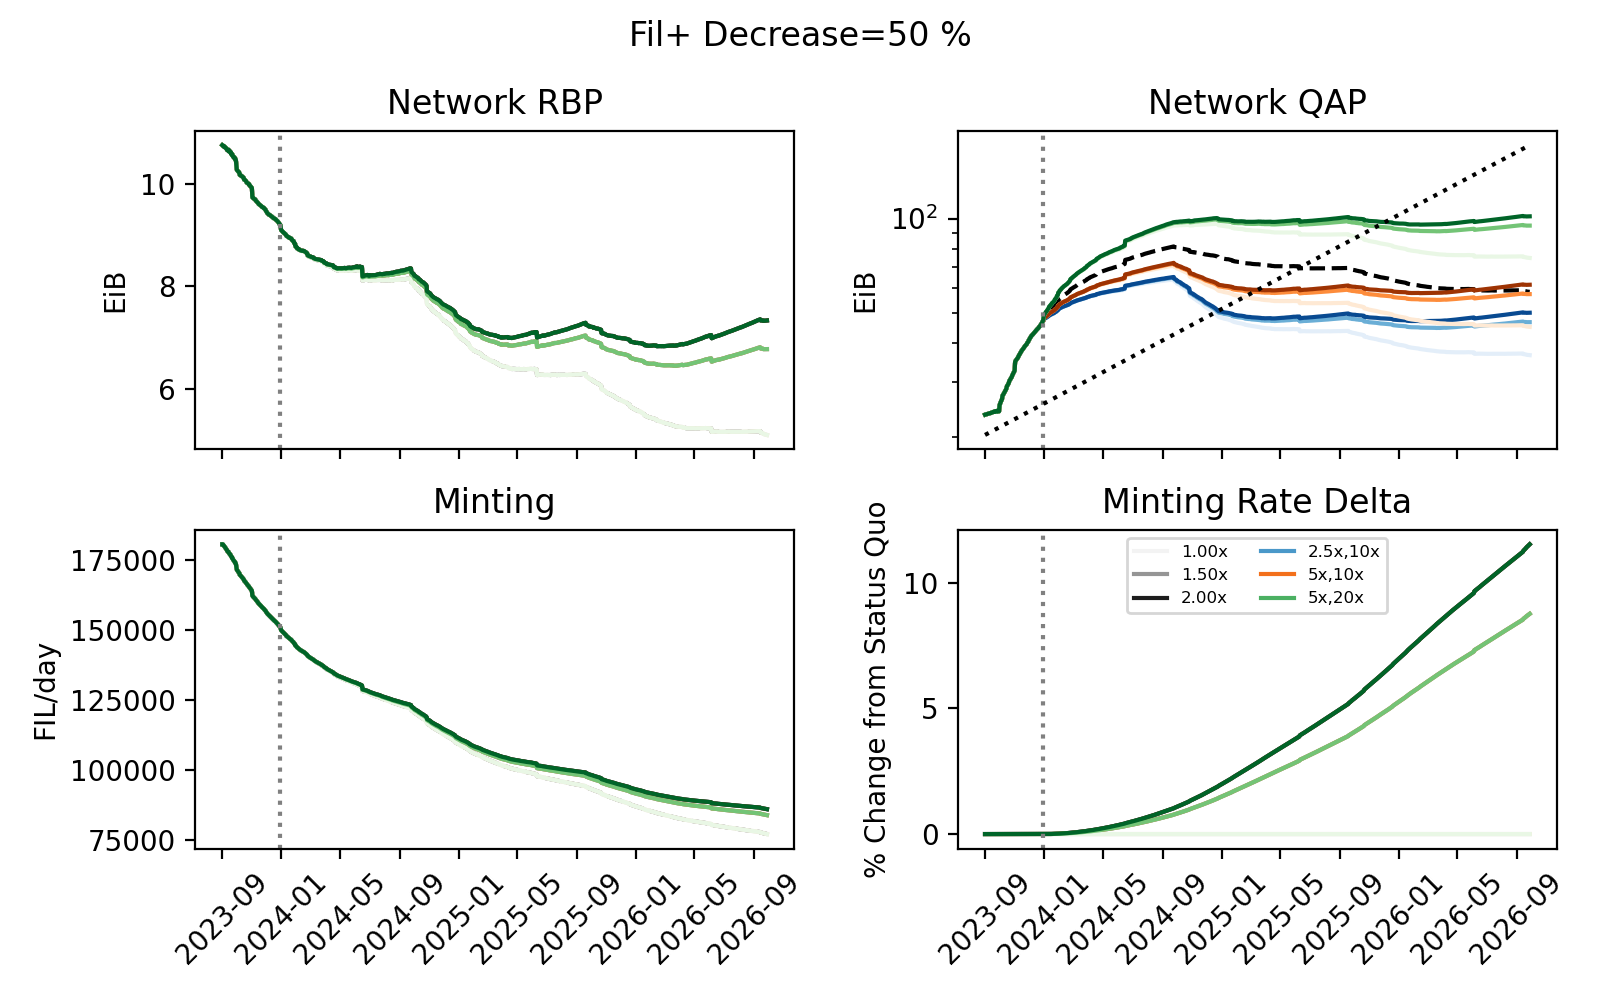

<IPython.core.display.Javascript object>


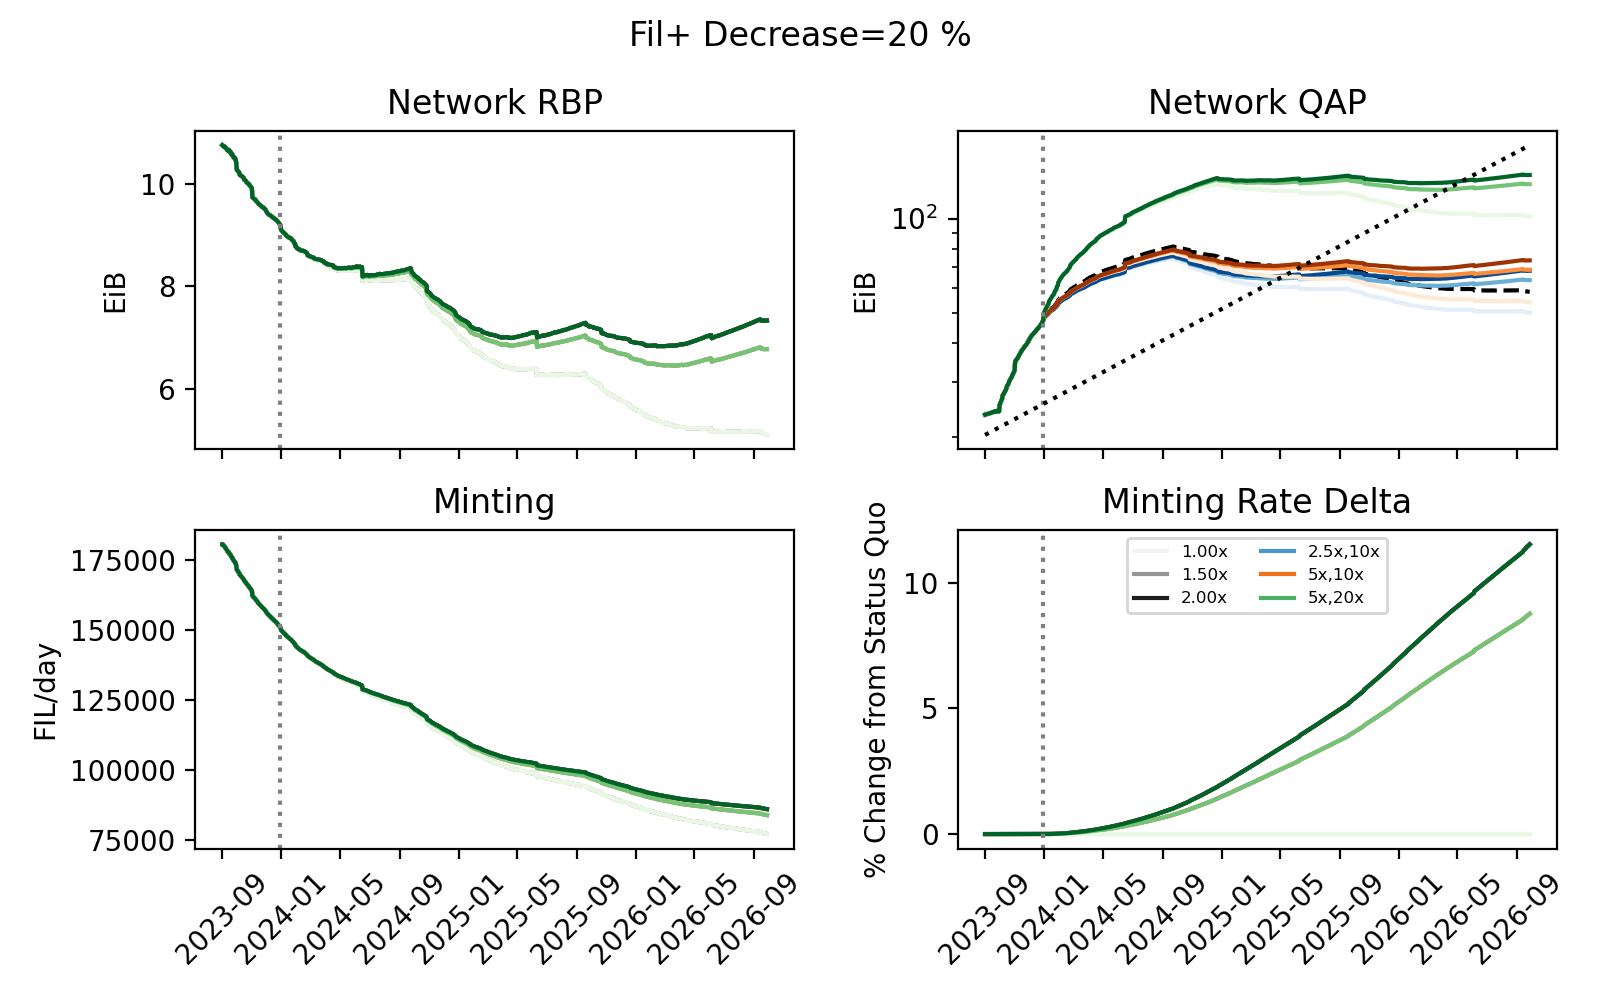

<IPython.core.display.Javascript object>


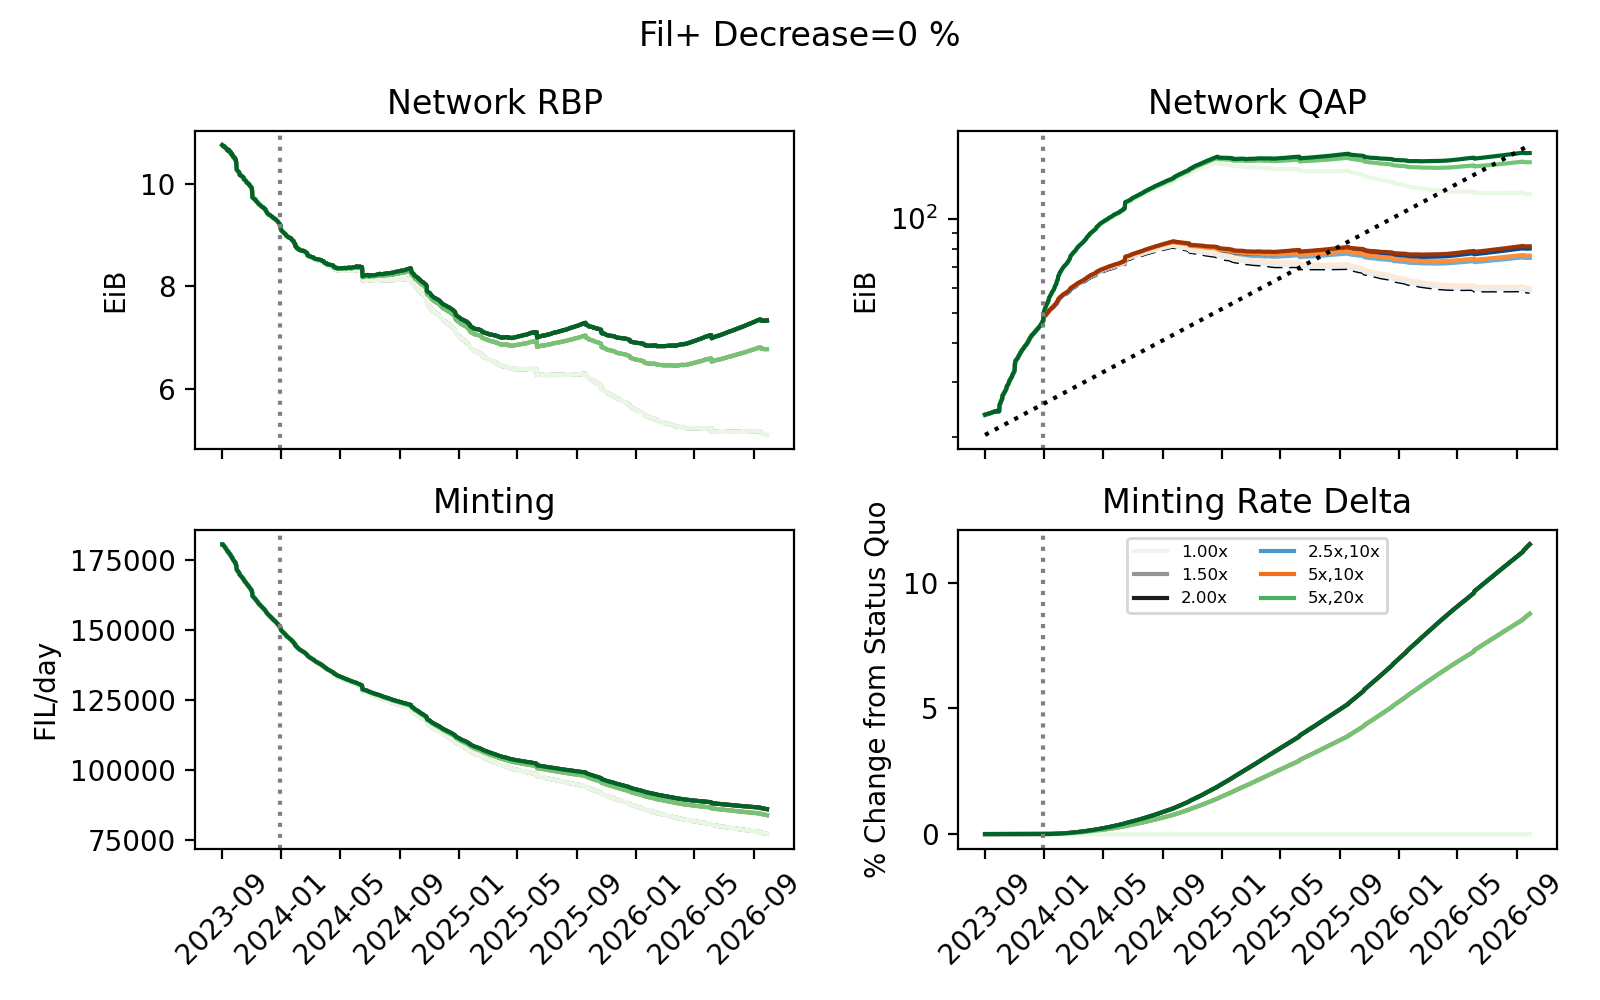

In [15]:
for filp_decrease_val in [0.5, 0.8, 1.0]:
    plot_power_panel(filp_decrease=filp_decrease_val, 
                     save_fp=os.path.join(results_folder, 
                                          'power_panel_allsectors_filpdecrease_%0.02f.png' % (filp_decrease_val,)))

<IPython.core.display.Javascript object>


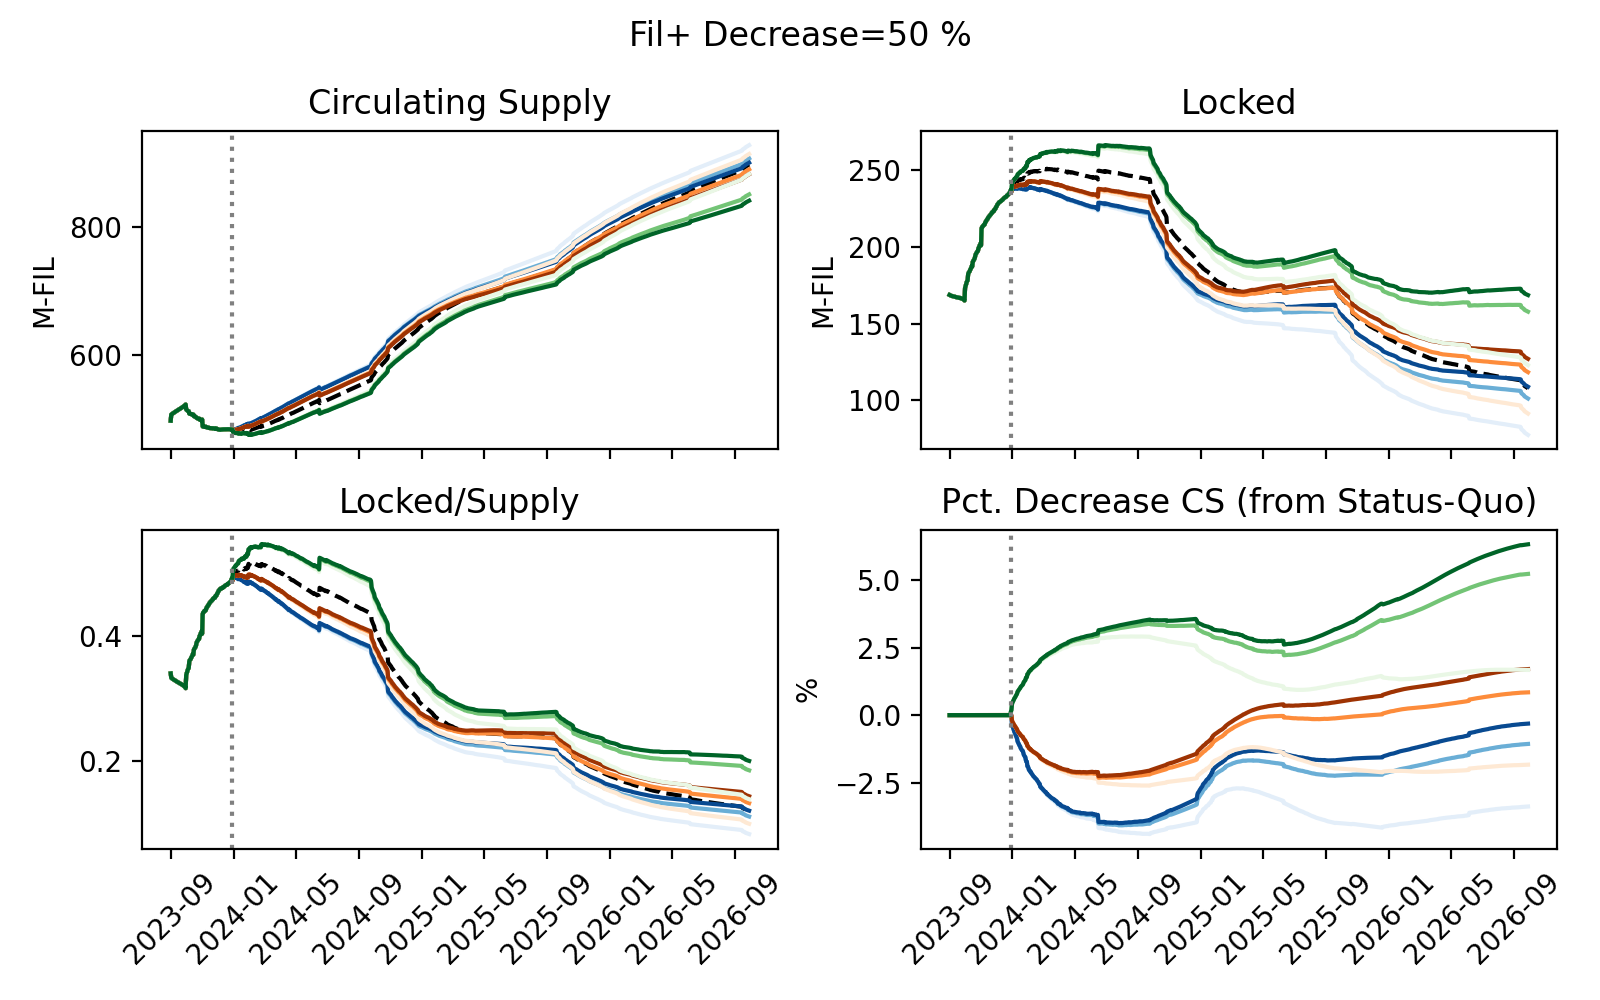

<IPython.core.display.Javascript object>


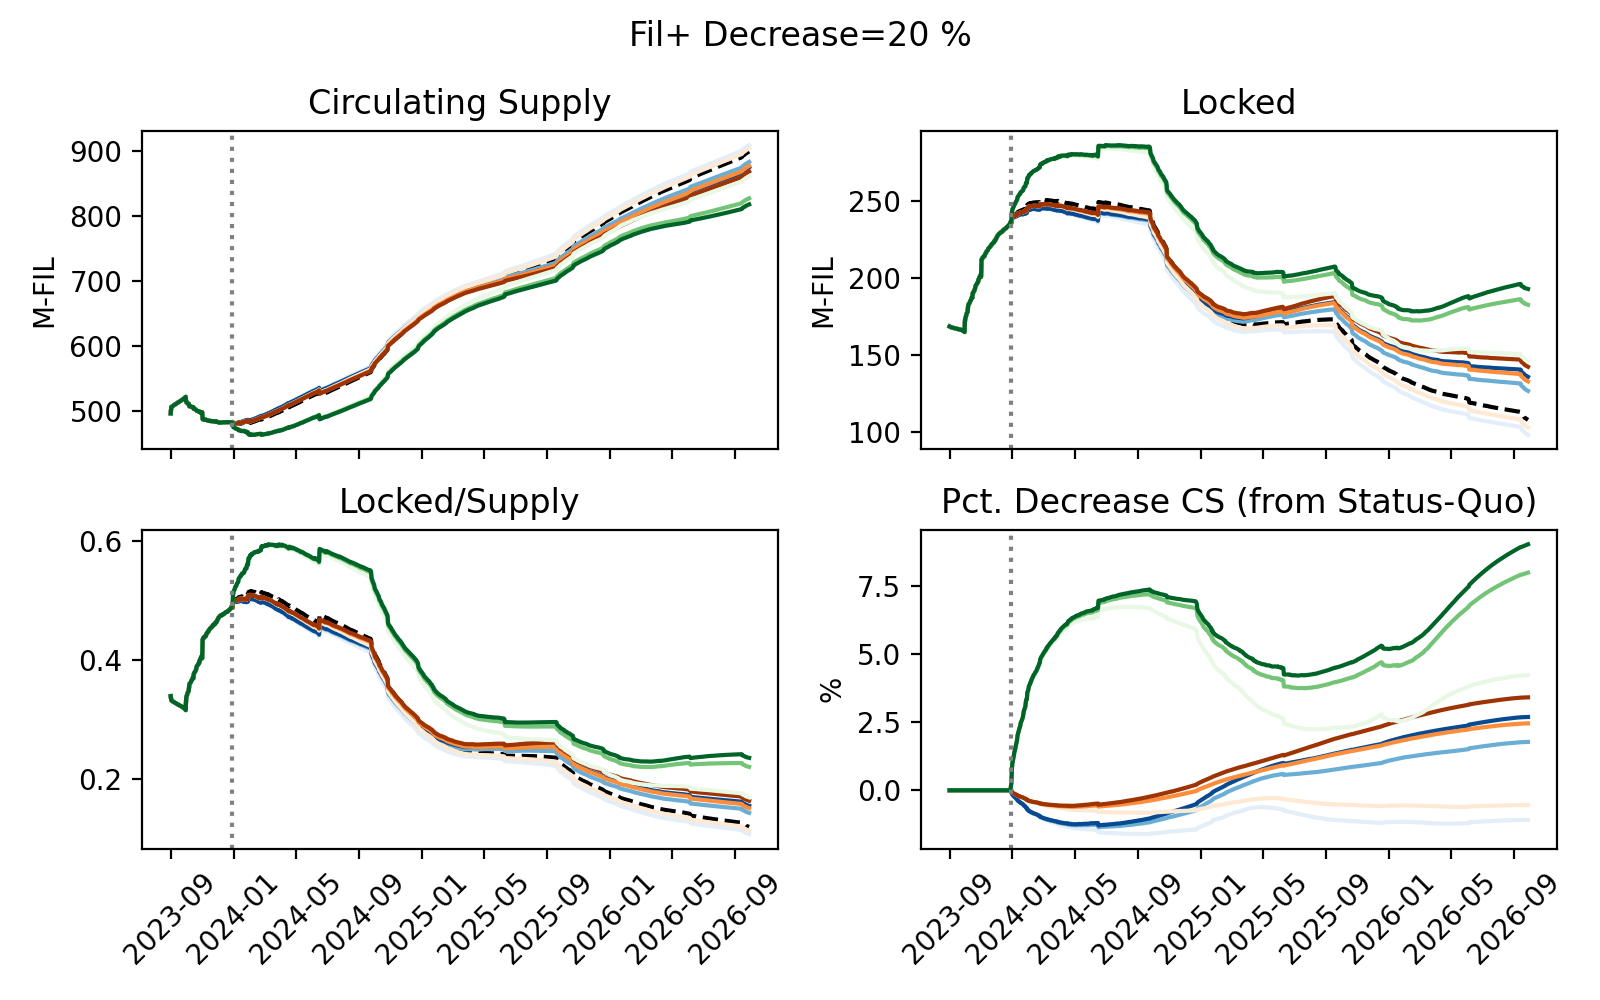

<IPython.core.display.Javascript object>


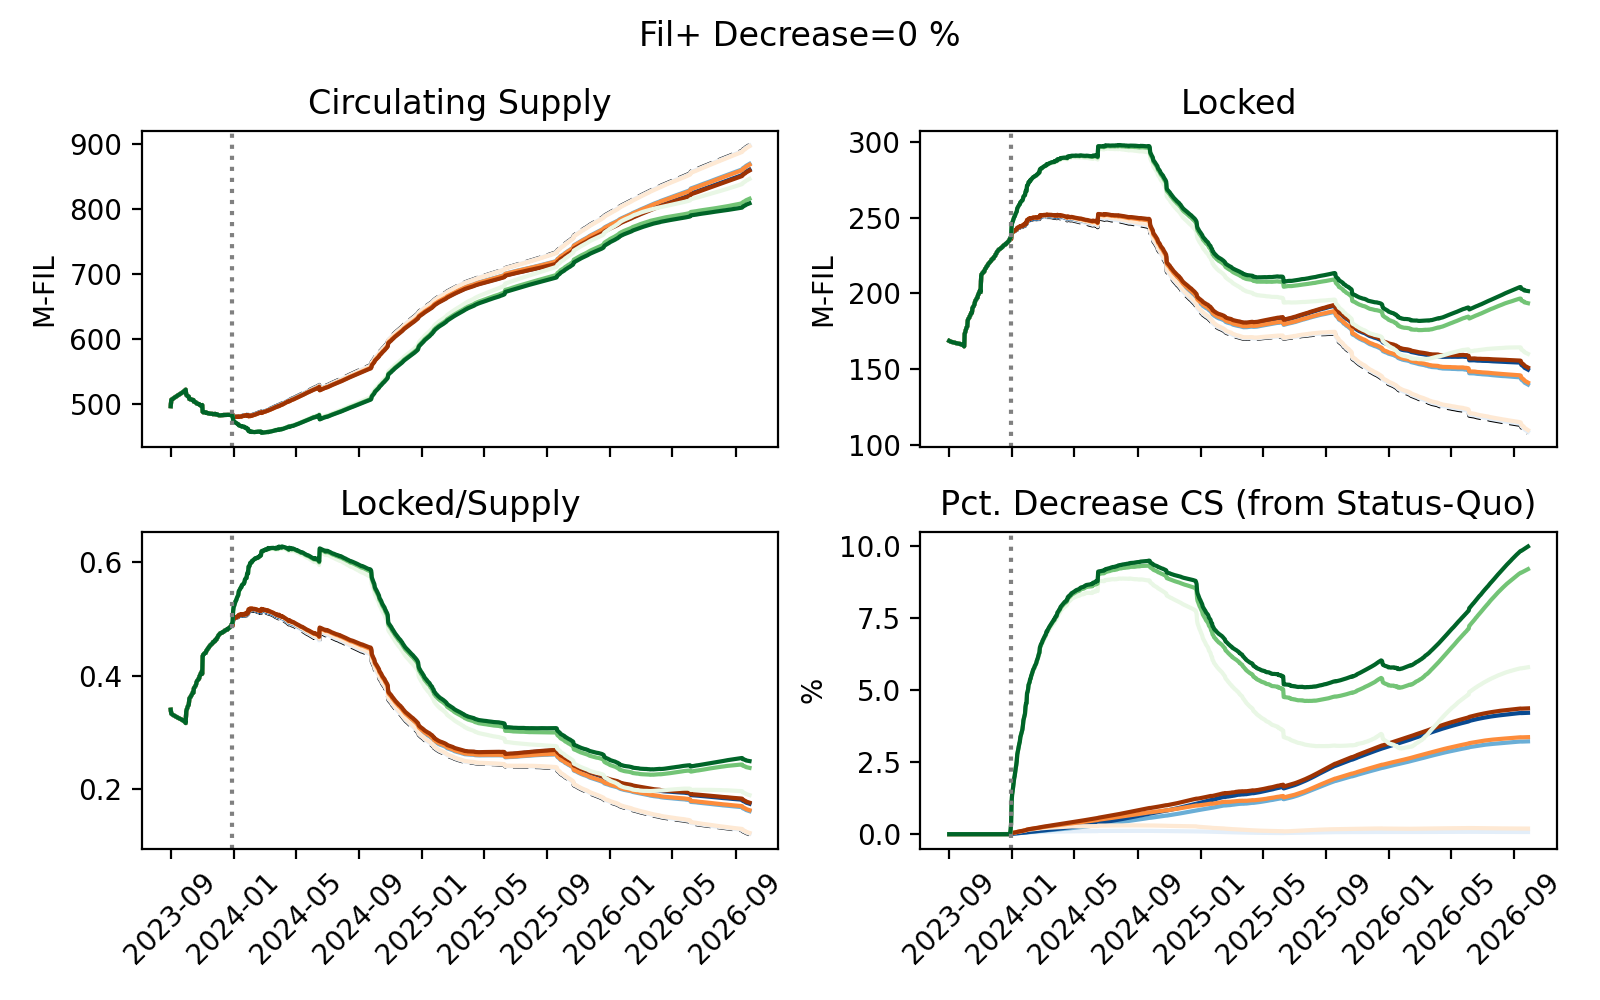

In [20]:
for filp_decrease_val in [0.5, 0.8, 1.0]:
    plot_supply_panel(filp_decrease=filp_decrease_val,
                      save_fp=os.path.join(results_folder, 'supply_panel_allsectors_%0.02f.png' % (filp_decrease_val,)))

<IPython.core.display.Javascript object>


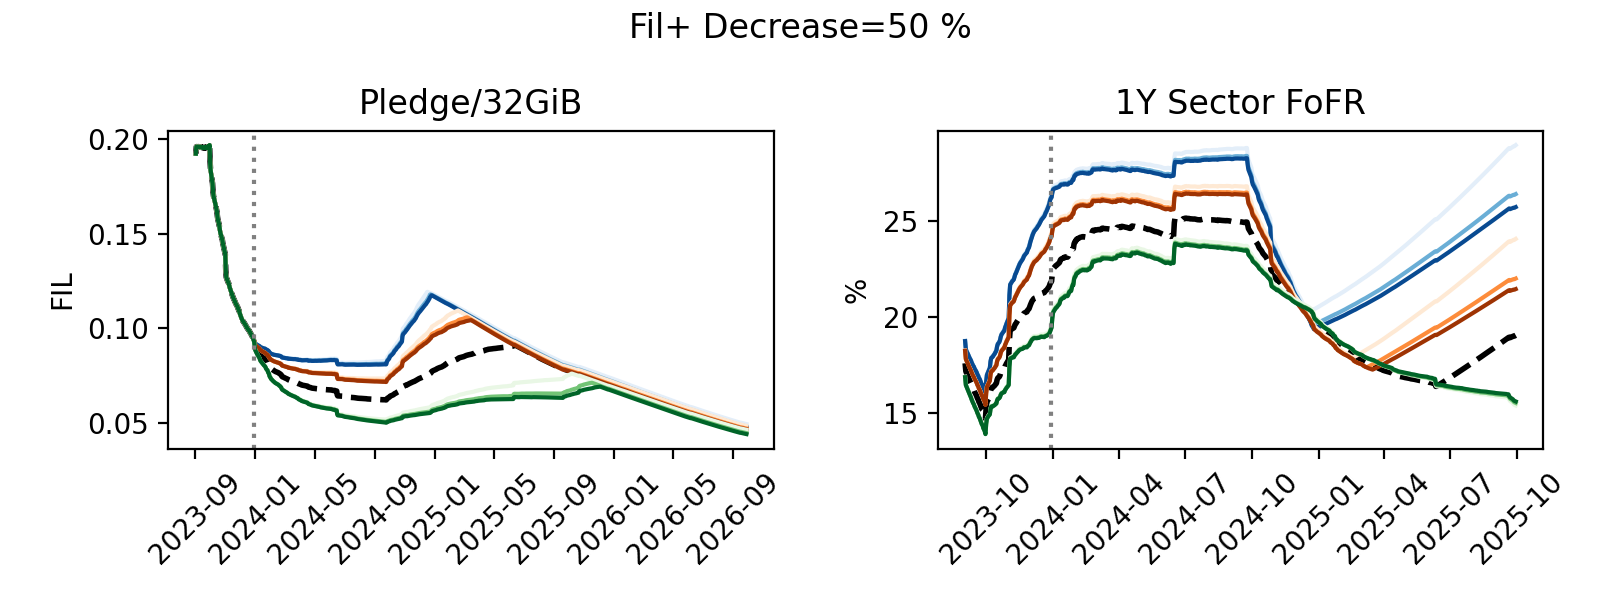

<IPython.core.display.Javascript object>


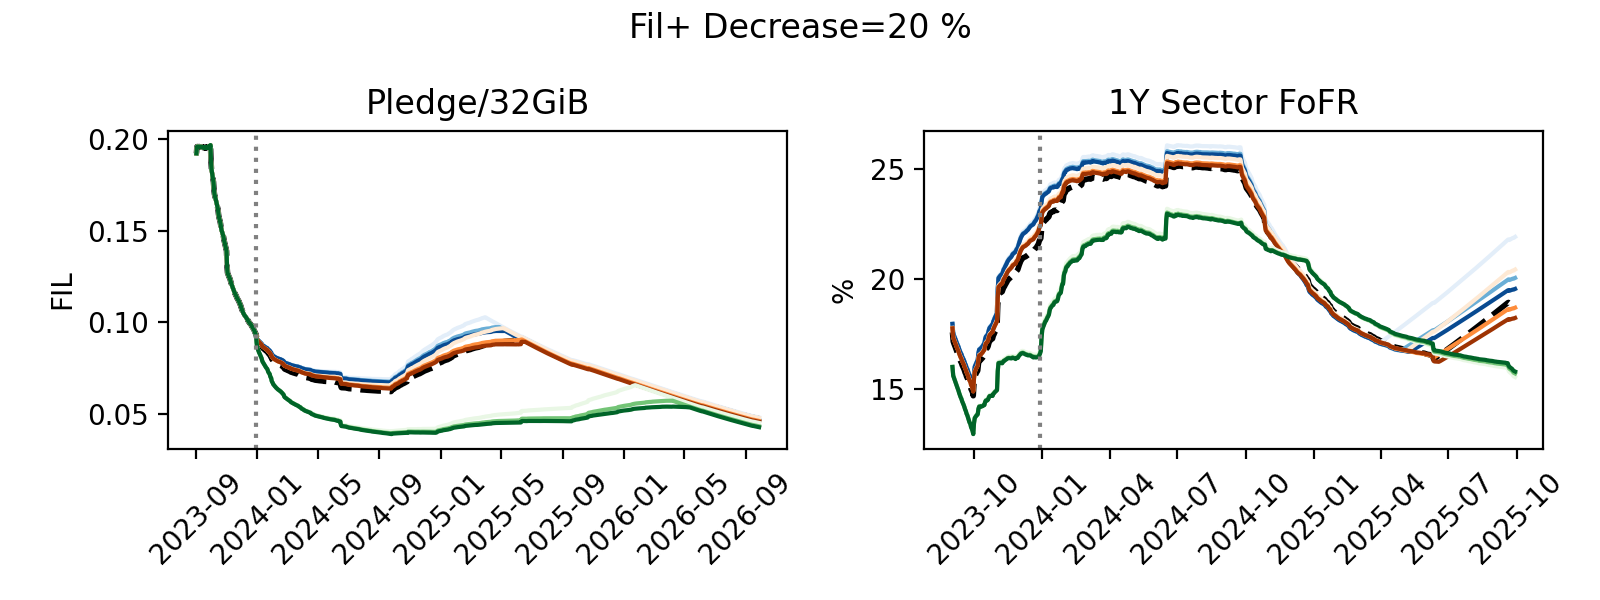

<IPython.core.display.Javascript object>


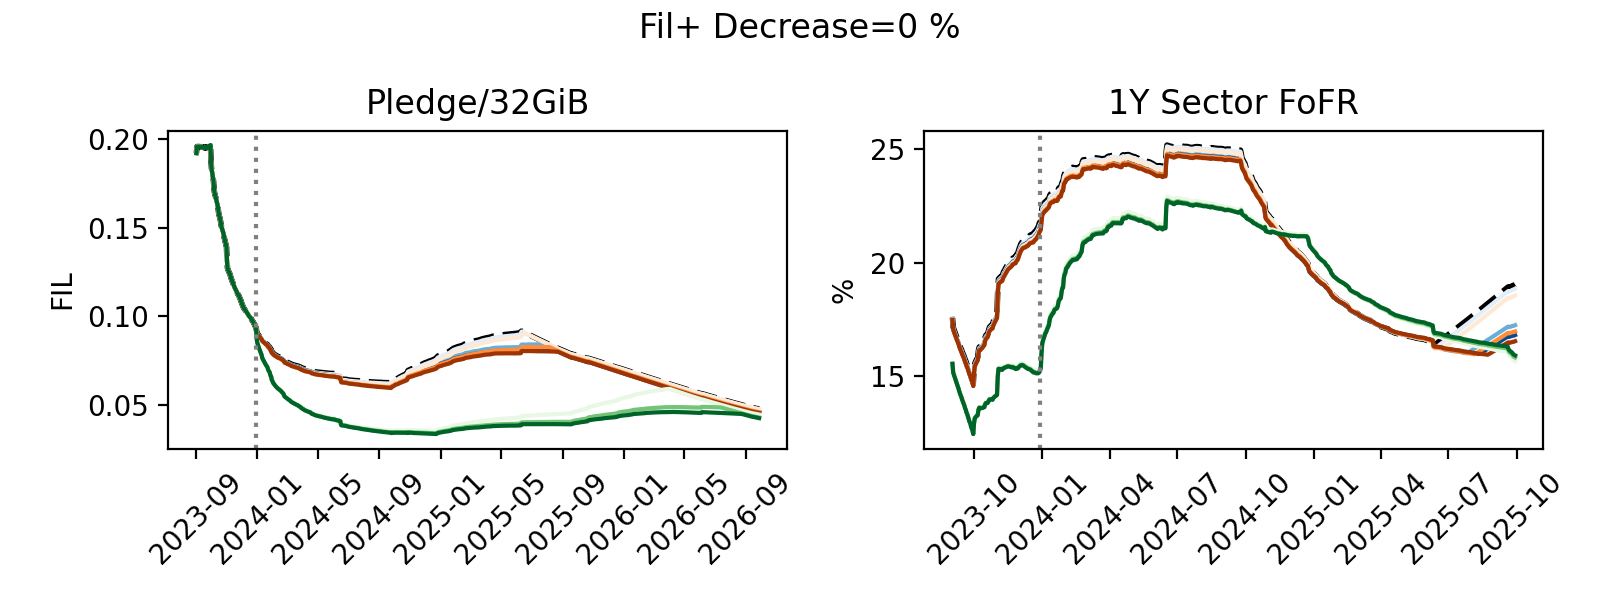

In [21]:
for filp_decrease_val in [0.5, 0.8, 1.0]:
    plot_incentive_panel(filp_decrease=filp_decrease_val,
                         save_fp=os.path.join(results_folder, 'incentives_panel_allsectors_%0.02f.png' % (filp_decrease_val,)))

<IPython.core.display.Javascript object>


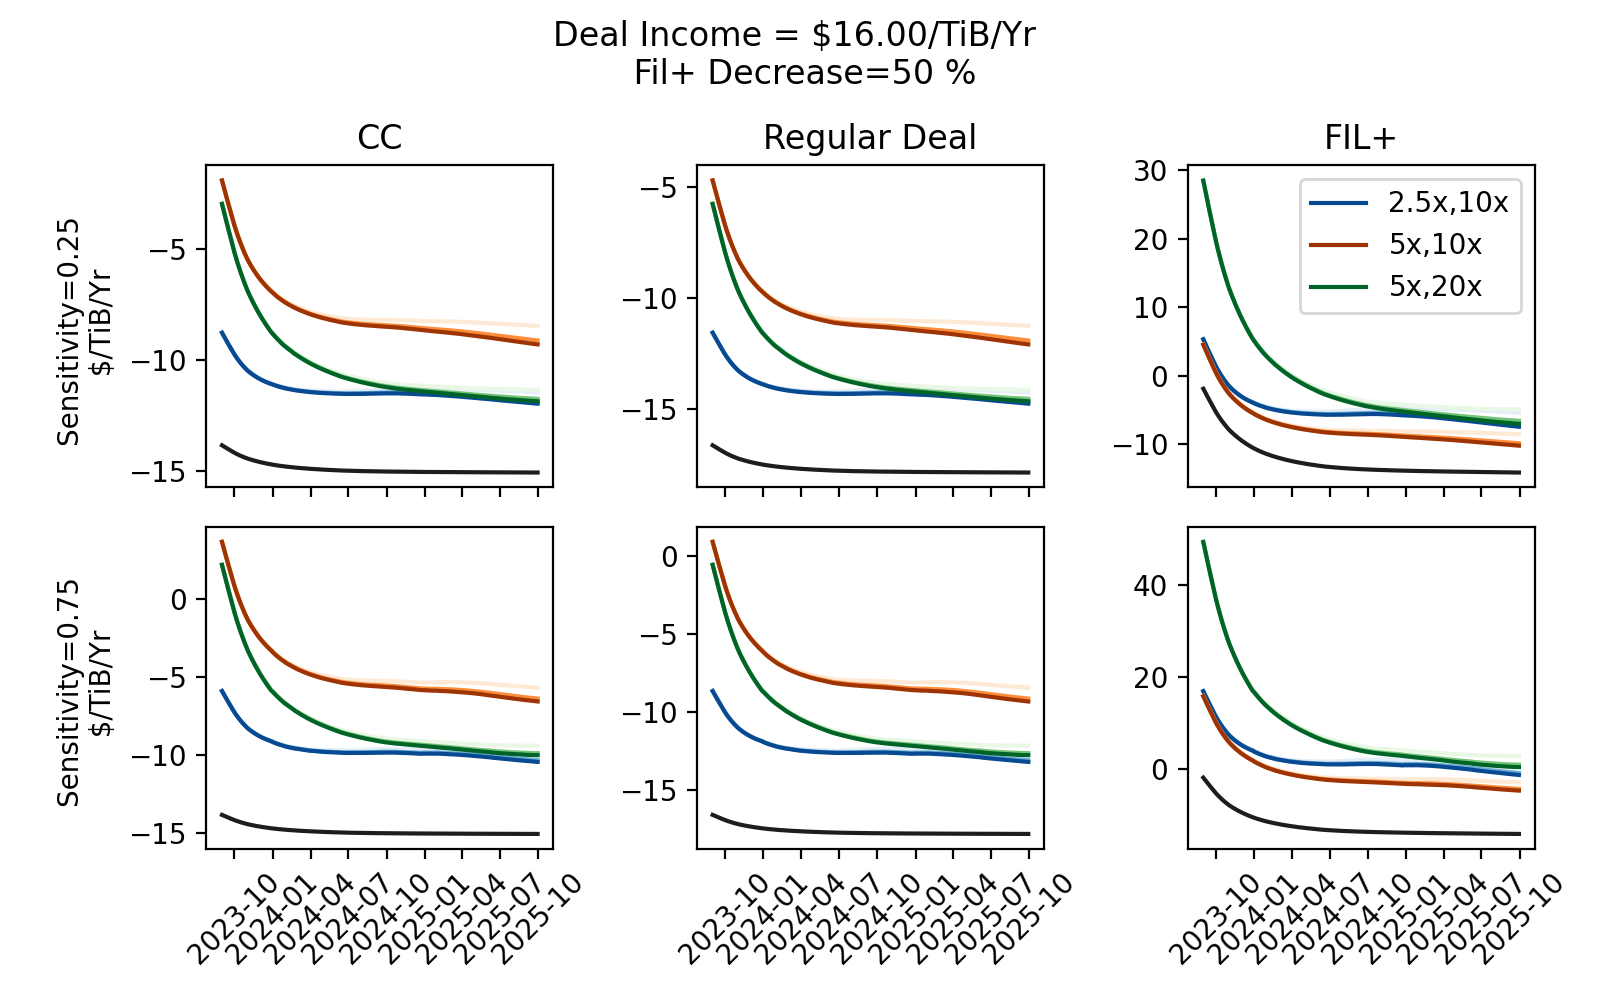

<IPython.core.display.Javascript object>


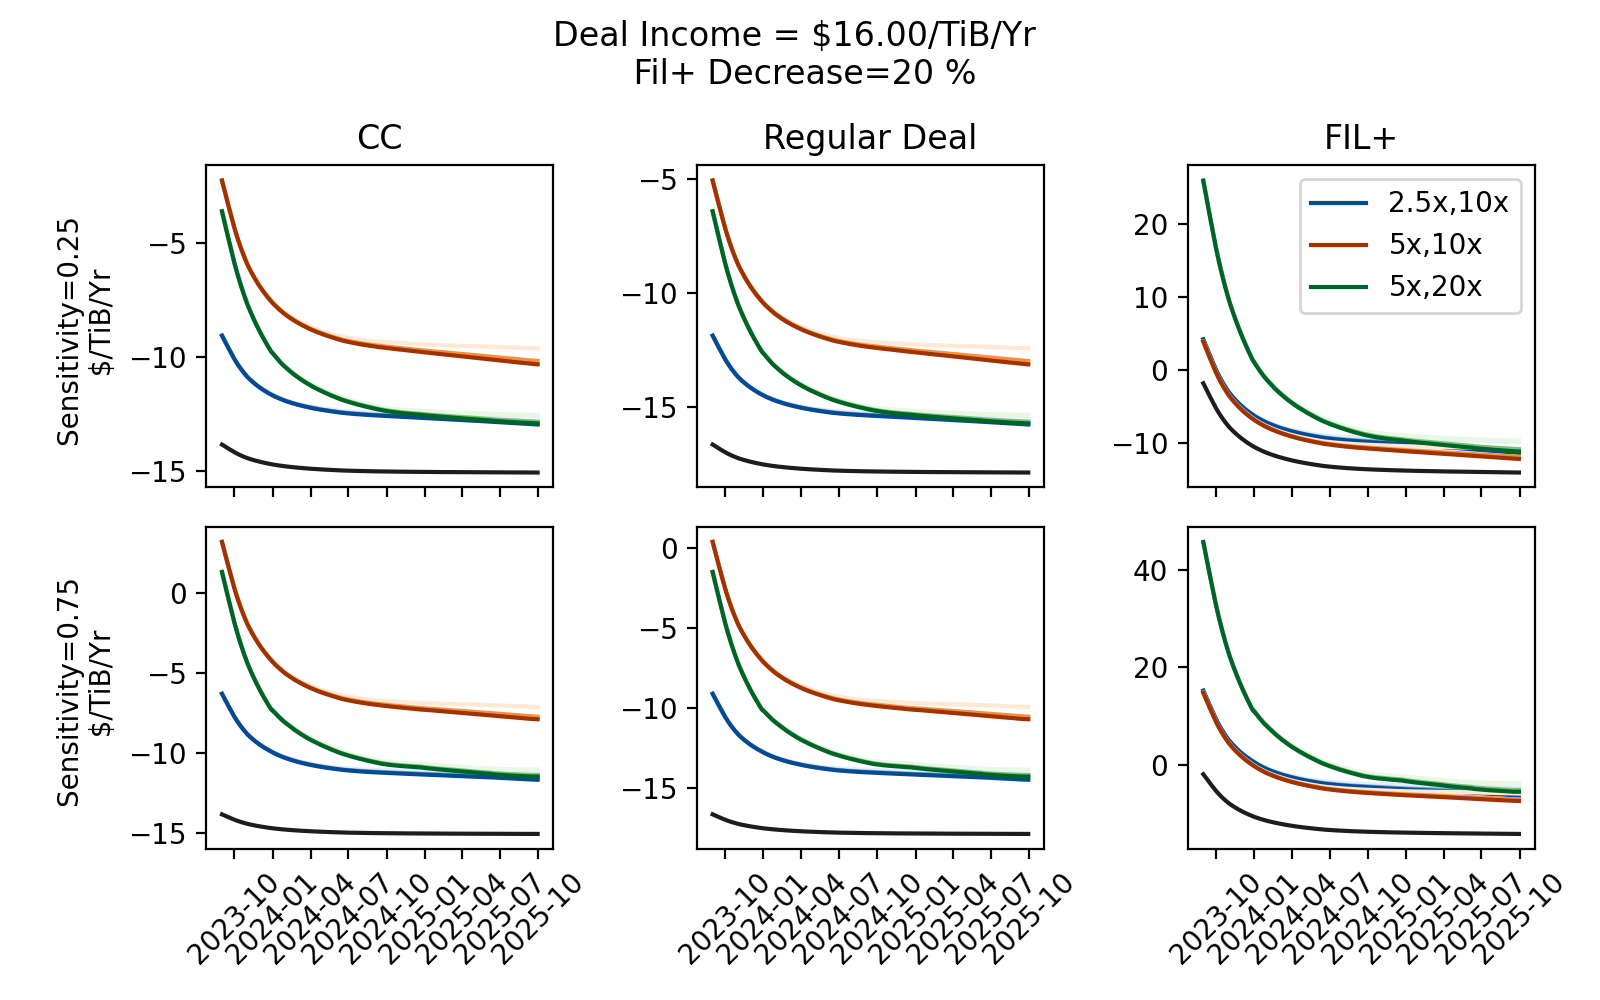

<IPython.core.display.Javascript object>


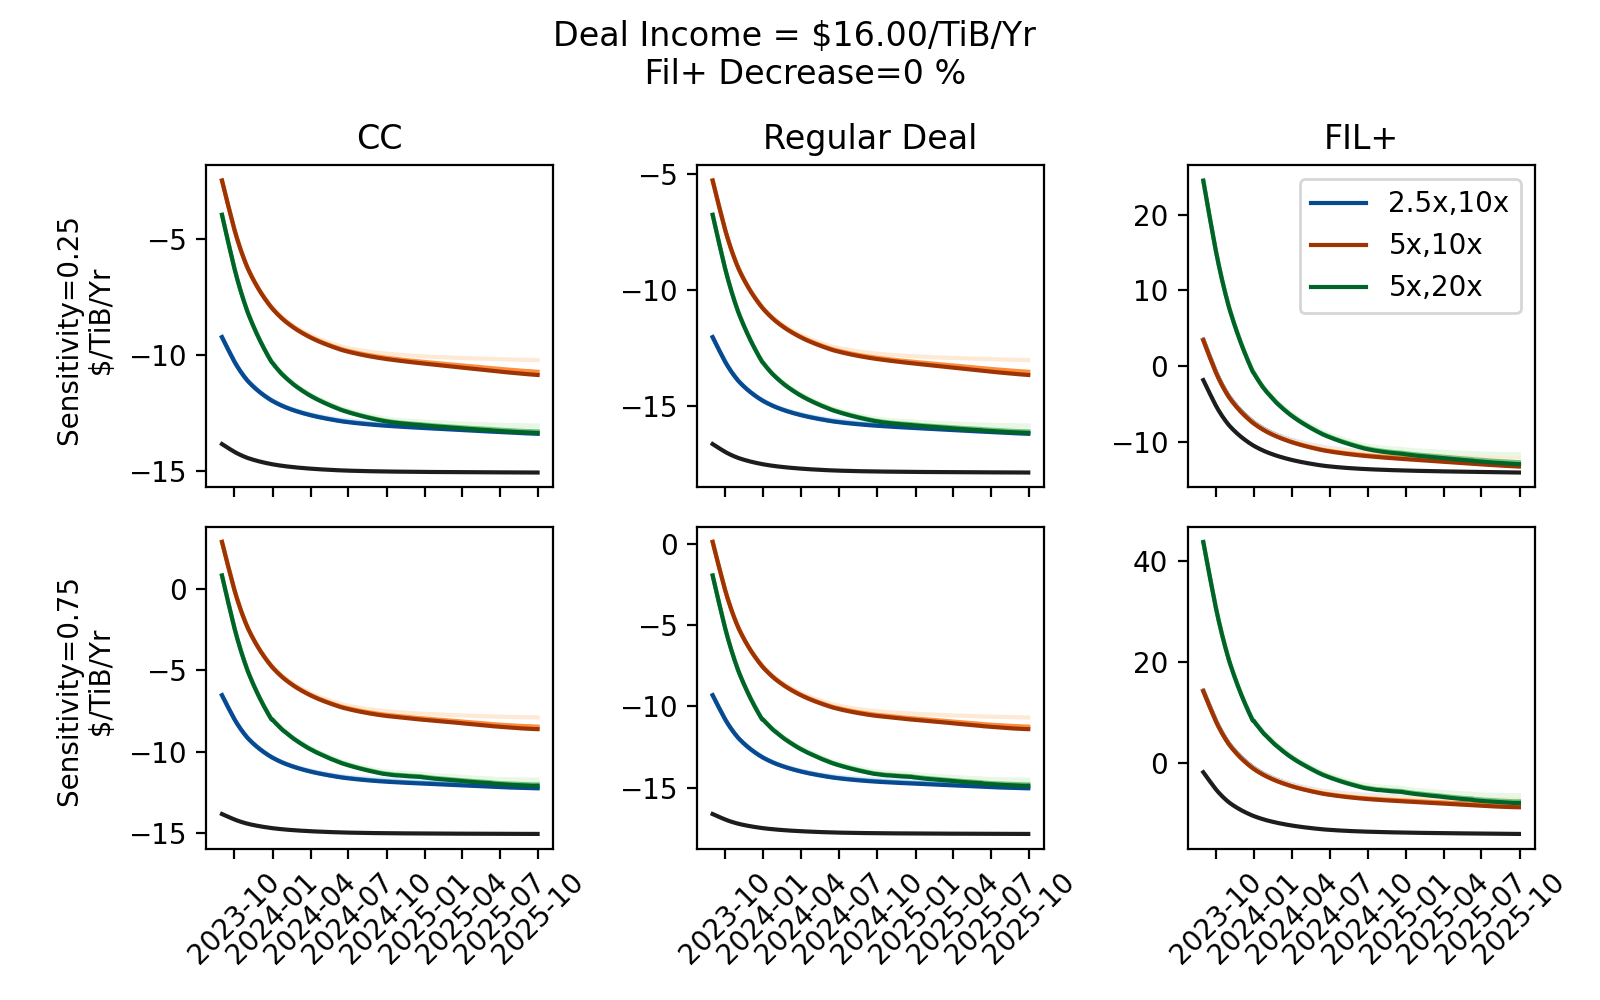

In [22]:
for filp_decrease_val in [0.5, 0.8, 1.0]:
    plot_roi_panel(filp_decrease=filp_decrease_val,
                   deal_income_tib_per_yr = 16, save_fp=os.path.join(results_folder, 'roi_panel_allsectors_%0.02f.png' % (filp_decrease_val,)))

In [23]:
def generate_laziness_panel(filp_decrease=1.0, deal_income_tib_per_yr = 16, save_fp=None):
#     fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(9,5))
    base_token_price = 4
    offset = (current_date-start_date).days
    
    status_quo_grp = get_sp_profile_profit(
        no_sdm['1y_return_per_sector'],
        no_sdm['network_locked'], no_sdm['network_locked'], # noops for status-quo
        deal_income_tib_per_yr = deal_income_tib_per_yr,
        base_token_price = base_token_price,
        sensitivity = 0,  # must be 0 for status-quo
        filp_multiplier=10, rd_multiplier=1, cc_multiplier=1,
    )
    sp_types = ['FIL+', 'V1-ExploitFIL+', 'V2-ExploitFIL+', 'V3-ExploitFIL+']
    sq_cc_profit = status_quo_grp.get_group('CC').reset_index()['profit'].values
    sq_results = {}
    for ii, sp_type in enumerate(sp_types):
        status_quo_profit = status_quo_grp.get_group(sp_type).reset_index()['profit'].values
        sq_results[sp_type] = status_quo_profit[offset] - sq_cc_profit[offset]
    alternative_rois = []
    # now plot for each multiplier configuration
    for ll, sensitivity in enumerate([0.25, 0.75]):
        for kk, sp_type in enumerate(sp_types):
            for ii, multiplier_cfg in enumerate(multiplier_cfgs):
                cfg_split_str = multiplier_cfg.split(',')
                cc_multiplier = float(cfg_split_str[0][:-1])
                rd_multiplier = cc_multiplier
                filp_multiplier = float(cfg_split_str[1][:-1])

                for jj, rbp_slope in enumerate(rbp_slopes):

                    key = '%s-RBPFactor=%0.02fx-FilpDecrease=%0.02f' % \
                        (multiplier_cfg, rbp_slope, filp_decrease)
                    res = results[key]['rbp_roi']
                    alternative_grp = get_sp_profile_profit(
                        res['1y_return_per_sector'],
                        no_sdm['network_locked'],
                        res['network_locked'], 
                        deal_income_tib_per_yr = deal_income_tib_per_yr,
                        base_token_price = base_token_price,
                        sensitivity = sensitivity,
                        filp_multiplier=filp_multiplier, 
                        rd_multiplier=rd_multiplier, 
                        cc_multiplier=cc_multiplier,
                    )
                    alternative_profit = alternative_grp.get_group(sp_type).reset_index()['profit'].values[offset]
                    cc_profit = alternative_grp.get_group('CC').reset_index()['profit'].values[offset]
                    alternative_rois.append({
                        'sensitivity': sensitivity,
                        'multiplier_cfg': multiplier_cfg,
                        'sp_type': sp_type,
                        'rbp_slope': rbp_slope,
                        'delta_roi': (alternative_profit-cc_profit),
                        'delta_roi_rel_sq': (alternative_profit-cc_profit)-sq_results[sp_type]
                    })
                    alternative_rois.append({
                        'sensitivity': sensitivity,
                        'multiplier_cfg': 'StatusQuo',
                        'sp_type': sp_type,
                        'rbp_slope': rbp_slope,
                        'delta_roi': sq_results[sp_type],
                        'delta_roi_rel_sq': 0
                    })
                    
    return sq_results, alternative_rois

<IPython.core.display.Javascript object>


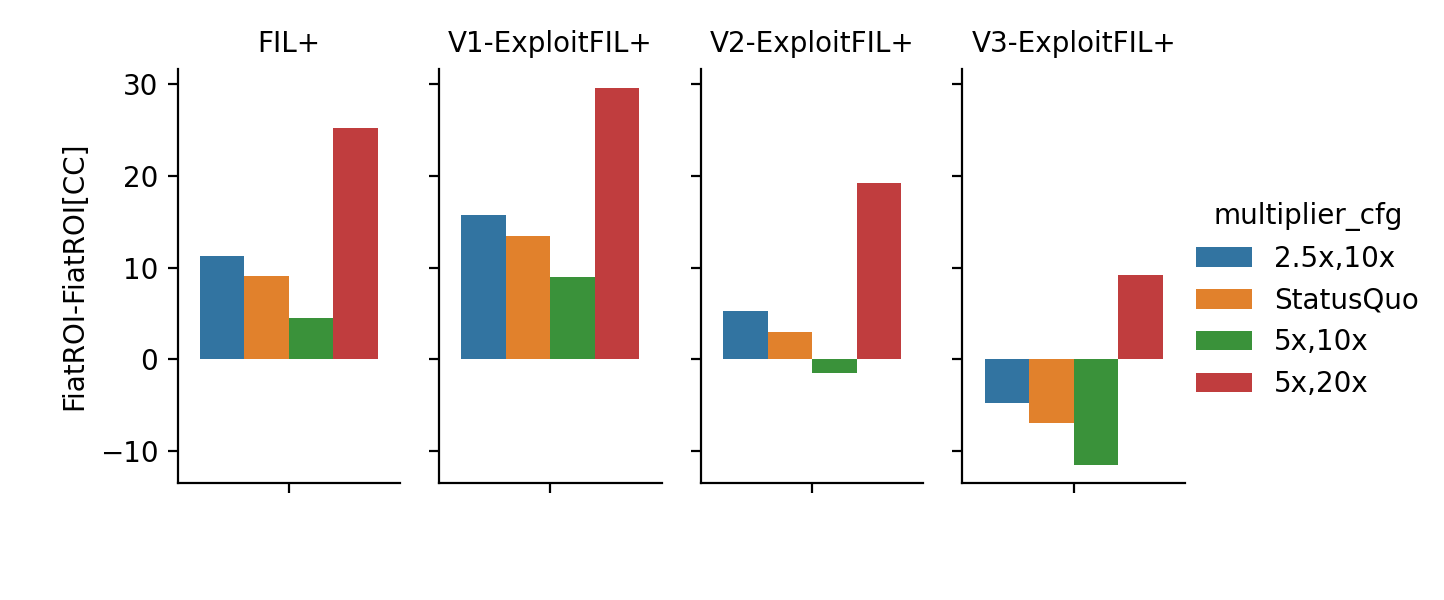

<IPython.core.display.Javascript object>


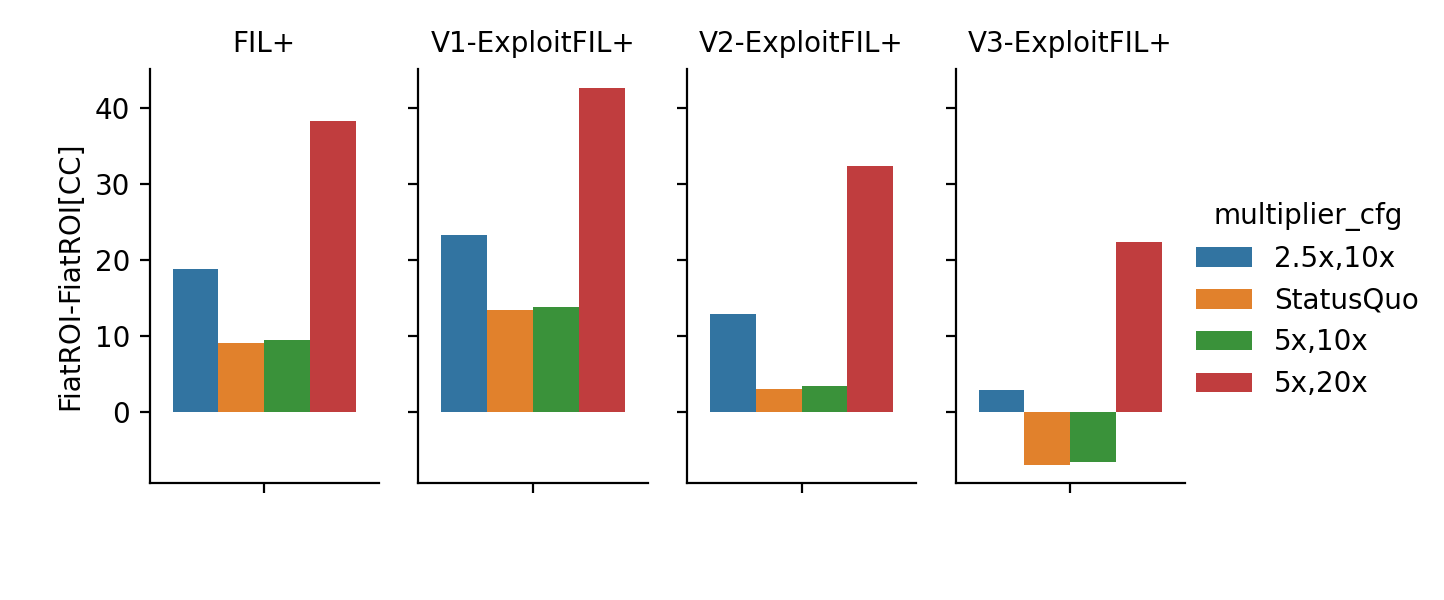

<IPython.core.display.Javascript object>


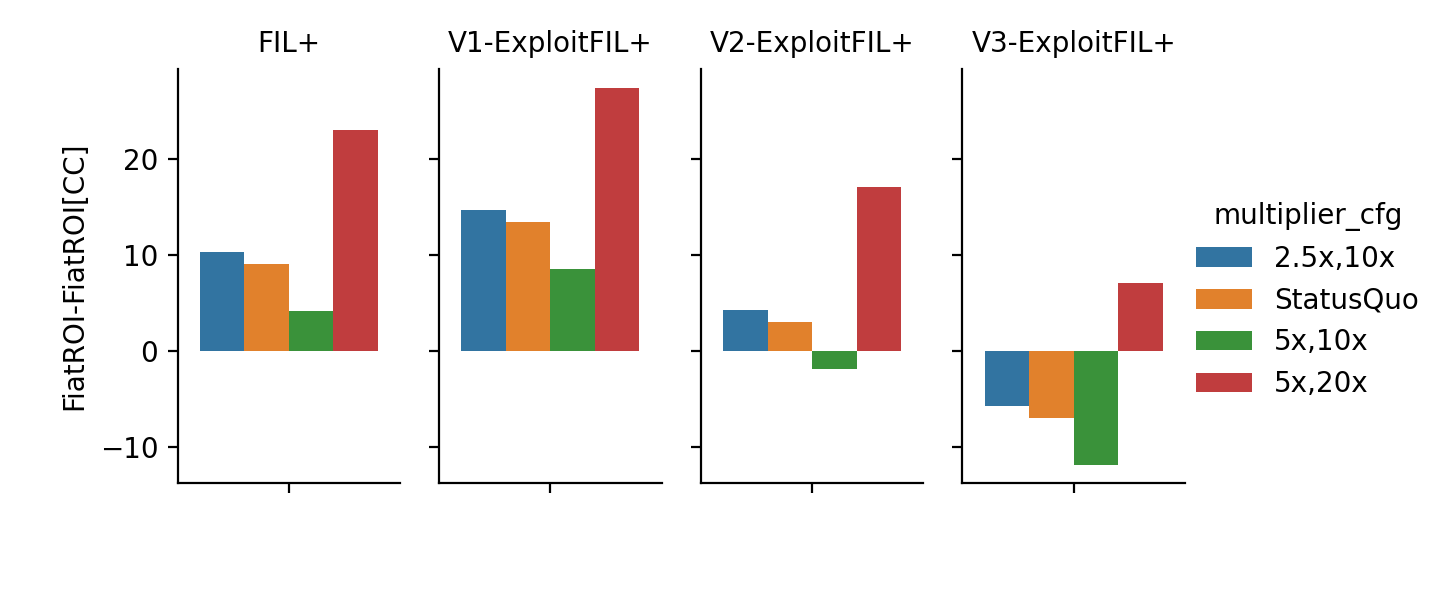

<IPython.core.display.Javascript object>


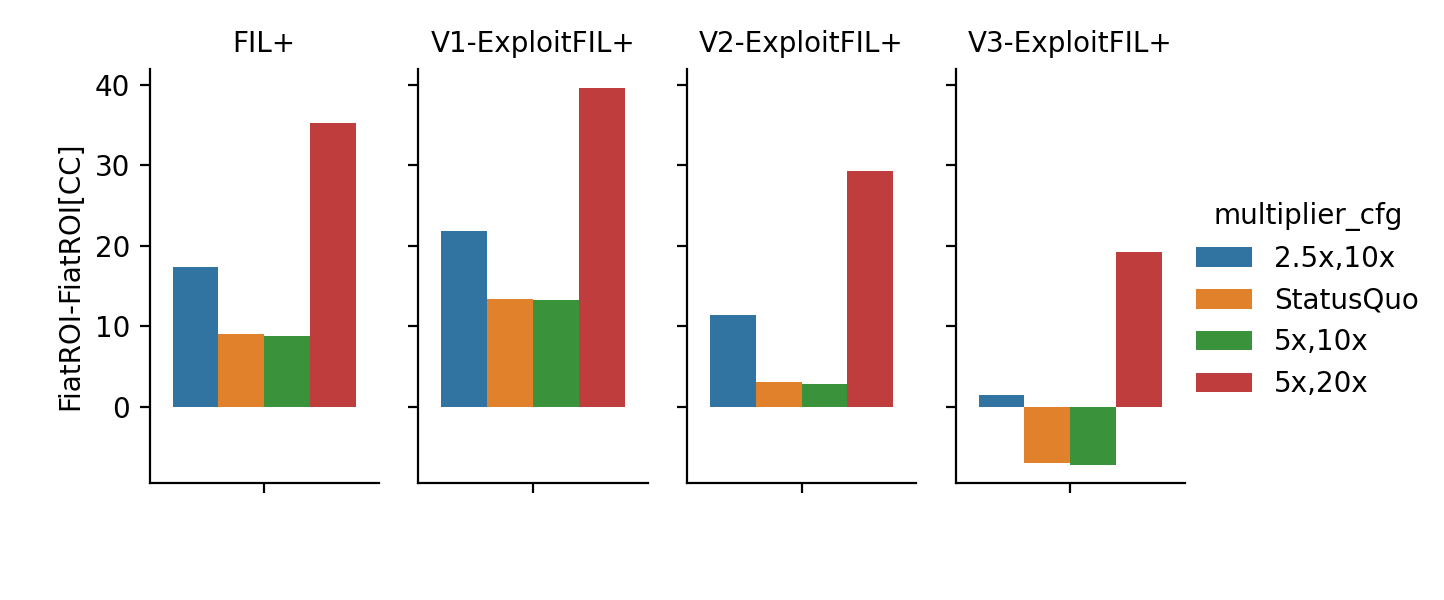

<IPython.core.display.Javascript object>


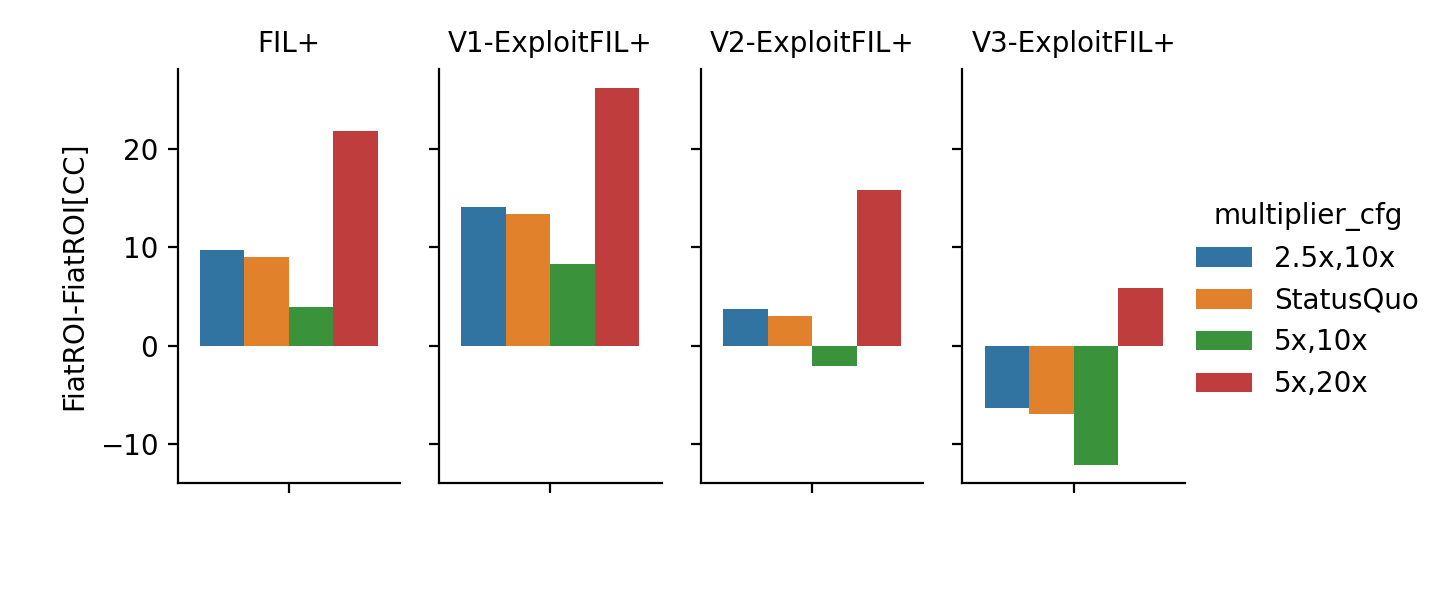

<IPython.core.display.Javascript object>


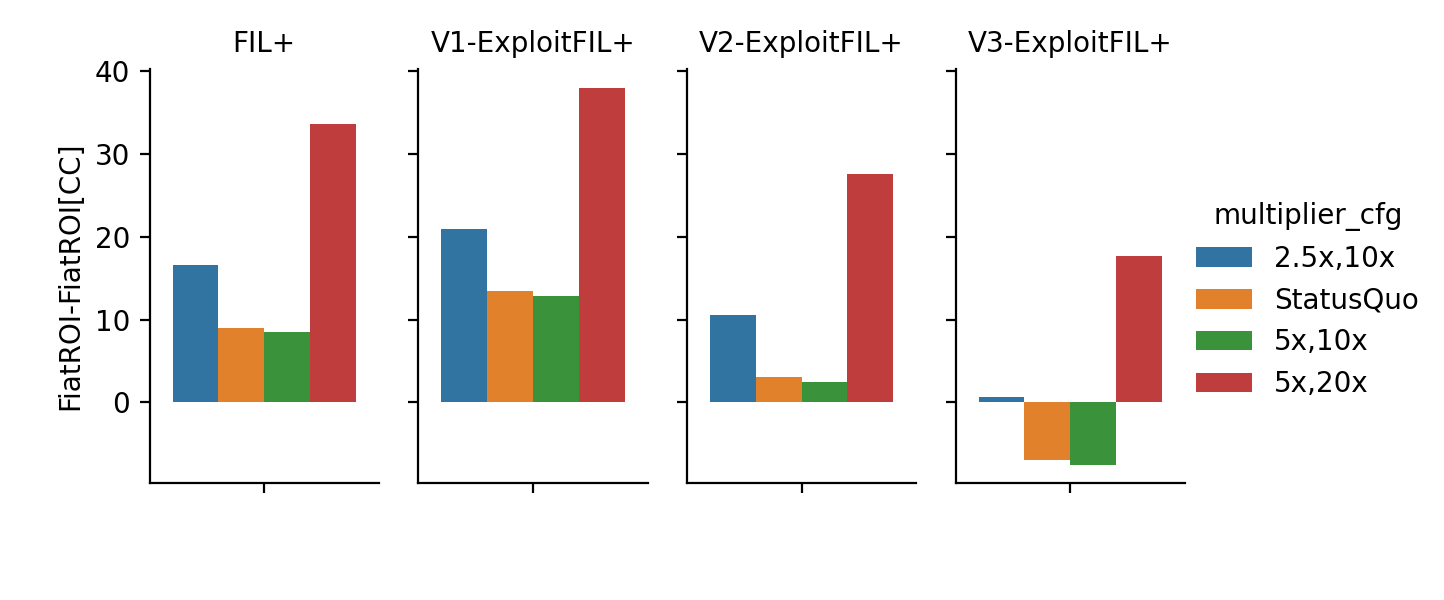

In [24]:
for filp_decrease_val in [0.5, 0.8, 1.0]:
    sq_results, alternative_rois = generate_laziness_panel(filp_decrease=filp_decrease_val)
    for sensitivity in [0.25, 0.75]:
    
        dff = pd.DataFrame(alternative_rois)
        dff = dff[dff['rbp_slope']==1.0]  # shouldn't matter, since return/sector at this time-point won't change too much 
        dff = dff[dff['sensitivity']==sensitivity]
        g = sns.catplot(
            dff, 
            kind='bar',
            x='sensitivity',
            y='delta_roi',
            hue='multiplier_cfg',
            col='sp_type',
            errorbar=None,
            height=3, aspect=0.5,
            row_order=['StatusQuo', '2.5x,10x', '5x,10x', '5x,20x']
        )
        g.set_axis_labels("", 'FiatROI-FiatROI[CC]')
        g.set_xticklabels([])
        g.set_titles("{col_name}")
        plt.savefig(os.path.join(results_folder, 'filp_considerations_sensitivity%0.02f_filpdecrease_%0.02f.png' % (sensitivity, filp_decrease_val,)))